In [39]:
import gzip
import pickle
import pandas as pd

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch

from decifer_refactored.utility import (
    generate_continuous_xrd_from_cif,
    extract_numeric_property,
    get_unit_cell_volume,
    extract_volume,
)

# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

In [277]:
def extract_validity_stats(df):
    validity_columns = [
        'formula_validity',
        'spacegroup_validity',
        'bond_length_validity',
        'site_multiplicity_validity',
        'validity',
    ]
    
    # Ensure the columns are treated as boolean
    df[validity_columns] = df[validity_columns].astype(bool)

    # Calculate the percentage of valid entries for each metric (mean)
    validity_stats_mean = df[validity_columns].mean() * 100
    
    # Calculate the 95% confidence interval
    n = len(df)  # Total number of samples
    z = 1.96  # z-score for 95% confidence level
    
    # Convert mean to proportion for CI calculation
    proportions = df[validity_columns].mean()
    validity_stats_95ci = z * np.sqrt((proportions * (1 - proportions)) / n) * 100  # Scale back to percentage

    # Calculate the standard deviation (for reference)
    validity_stats_std = df[validity_columns].std() * 100
    
    # Combine mean, 95% CI, and standard deviation into a single DataFrame
    validity_stats = pd.DataFrame({
        'mean (%)': validity_stats_mean,
        '95% CI (%)': validity_stats_95ci,
        'std (%)': validity_stats_std
    })

    return validity_stats

In [278]:
def extract_metrics_stats(df):
    metrics_columns = [
        'rwp',
        'wd',
    ]

    # Ensure the columns are numeric
    df_metrics = df[metrics_columns].apply(pd.to_numeric, errors='coerce')
    
    # Calculate the mean and standard deviation for each metric
    metrics_mean = df_metrics.mean()
    metrics_std = df_metrics.std()
    
    # Combine mean and standard deviation into a single DataFrame
    metrics_stats = pd.DataFrame({
        'mean': metrics_mean,
        'std': metrics_std
    })
    metrics_stats['Metric'] = metrics_stats.index  # Add the metric names as a column
    
    return metrics_stats.reset_index(drop=True)


In [280]:
import warnings
warnings.filterwarnings("ignore")

# Define the function to process a file and extract metrics
def process_file(file_path):

    warnings.filterwarnings("ignore")
    # Load the data
    with gzip.open(file_path, 'rb') as f:
        df = pd.DataFrame(pickle.load(f))
    
    metrics_list = []
    for i, entry in df.iterrows():
        try:
            cif_sample = entry['cif_sample']
            a_sample = extract_numeric_property(cif_sample, prop='_cell_length_a')
            b_sample = extract_numeric_property(cif_sample, prop='_cell_length_b')
            c_sample = extract_numeric_property(cif_sample, prop='_cell_length_c')
        
            alpha_sample = extract_numeric_property(cif_sample, prop='_cell_angle_alpha')
            beta_sample = extract_numeric_property(cif_sample, prop='_cell_angle_beta')
            gamma_sample = extract_numeric_property(cif_sample, prop='_cell_angle_gamma')
        
            implied_vol_sample = get_unit_cell_volume(a_sample, b_sample, c_sample, alpha_sample, beta_sample, gamma_sample)
            gen_vol_sample = extract_volume(cif_sample)

            cif_gen = entry['cif_gen']
            a_gen = extract_numeric_property(cif_gen, prop='_cell_length_a')
            b_gen = extract_numeric_property(cif_gen, prop='_cell_length_b')
            c_gen = extract_numeric_property(cif_gen, prop='_cell_length_c')
            
            alpha_gen = extract_numeric_property(cif_gen, prop='_cell_angle_alpha')
            beta_gen = extract_numeric_property(cif_gen, prop='_cell_angle_beta')
            gamma_gen = extract_numeric_property(cif_gen, prop='_cell_angle_gamma')
            
            implied_vol_gen = get_unit_cell_volume(a_gen, b_gen, c_gen, alpha_gen, beta_gen, gamma_gen)
            gen_vol_gen = extract_volume(cif_gen)

            # Extract Validity
            formula_validity = entry['formula_validity']
            bond_length_validity = entry['bond_length_validity']
            spacegroup_validity = entry['spacegroup_validity']
            site_multiplicity_validity = entry['site_multiplicity_validity']
            valid = all([formula_validity, bond_length_validity, spacegroup_validity, site_multiplicity_validity])

            # Metrics
            rwp = entry['rwp']
            wd = entry['wd']
            
            metrics_list.append({
                'a_sample': a_sample,
                'b_sample': b_sample,
                'c_sample': c_sample,
                'alpha_sample': alpha_sample,
                'beta_sample': beta_sample,
                'gamma_sample': gamma_sample,
                'implied_vol_sample': implied_vol_sample,
                'gen_vol_sample': gen_vol_sample,
                'a_gen': a_gen,
                'b_gen': b_gen,
                'c_gen': c_gen,
                'alpha_gen': alpha_gen,
                'beta_gen': beta_gen,
                'gamma_gen': gamma_gen,
                'implied_vol_gen': implied_vol_gen,
                'gen_vol_gen': gen_vol_gen,
                'formula_validity':formula_validity,
                'bond_length_validity':bond_length_validity,
                'spacegroup_validity':spacegroup_validity,
                'site_multiplicity_validity':site_multiplicity_validity,
                'validity':valid,
                'rwp': rwp,
                'wd': wd,
            })
        except Exception as e:
            continue

    return pd.DataFrame(metrics_list)

# File paths
file_path_deCIFer = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz"
file_path_UdeCIFer = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer-U_(CompSG).pkl.gz"


# Process and save for each file path
decifer = process_file(file_path_deCIFer)
udecifer = process_file(file_path_UdeCIFer)


## Validity and metrics

In [282]:
print("U-deCIFer baseline")
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer-U_(None).pkl.gz"
print("None")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer-U_(Comp).pkl.gz"
print("Comp")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer-U_(CompSG).pkl.gz"
print("CompSG")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))

U-deCIFer baseline
None
                             mean (%)  95% CI (%)    std (%)
formula_validity            99.281768    0.117297   8.444580
spacegroup_validity         98.759417    0.153753  11.069118
bond_length_validity        93.340030    0.346330  24.933371
site_multiplicity_validity  98.754395    0.154060  11.091220
validity                    92.164741    0.373276  26.873237
       mean       std Metric
0  1.283787  0.252341    rwp
1  0.348297  0.153504     wd

Comp
                             mean (%)  95% CI (%)    std (%)
formula_validity            99.583751    0.089364   6.438454
spacegroup_validity         98.721163    0.155957  11.236305
bond_length_validity        93.029087    0.353466  25.466256
site_multiplicity_validity  98.911735    0.144007  10.375334
validity                    91.965898    0.377290  27.182724
       mean       std Metric
0  0.857852  0.418299    rwp
1  0.142161  0.131708     wd

CompSG
                             mean (%)  95% CI (%)    std

In [283]:
print("decifer baseline")
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(None_N-0p00_B-0p05).pkl.gz"
print("None")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p00_B-0p05).pkl.gz"
print("Comp")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz"
print("CompSG")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))

decifer baseline
None
                             mean (%)  95% CI (%)    std (%)
formula_validity            98.864436    0.147209  10.595875
spacegroup_validity         98.366998    0.176086  12.674445
bond_length_validity        92.116370    0.374403  26.948986
site_multiplicity_validity  98.402171    0.174211  12.539449
validity                    90.302482    0.411138  29.593140
       mean       std Metric
0  0.473291  0.368985    rwp
1  0.175700  0.225195     wd

Comp
                             mean (%)  95% CI (%)    std (%)
formula_validity            99.493633    0.098505   7.098087
spacegroup_validity         99.007320    0.137584   9.914007
bond_length_validity        93.111401    0.351475  25.326652
site_multiplicity_validity  98.952171    0.141314  10.182837
validity                    92.299208    0.369994  26.661070
       mean       std Metric
0  0.400377  0.332811    rwp
1  0.145305  0.221627     wd

CompSG
                             mean (%)  95% CI (%)    std (

In [315]:
print("decifer robustness")
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p05_B-0p10).pkl.gz"
print("Comp_N-0p05_B-0p10")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p10_B-0p05).pkl.gz"
print("Comp_N-0p10_B-0p05")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p00_B-0p20).pkl.gz"
print("Comp_N-0p00_B-0p20")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_(Comp_N-0p10_B-0p20).pkl.gz"
print("Comp_N-0p10_B-0p20")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))

decifer robustness
Comp_N-0p05_B-0p10
                             mean (%)  95% CI (%)    std (%)
formula_validity            99.544042    0.093469   6.737220
spacegroup_validity         98.862611    0.147119  10.604284
bond_length_validity        92.809901    0.358395  25.833038
site_multiplicity_validity  98.917727    0.143550  10.347044
validity                    91.913017    0.378250  27.264193
       mean       std Metric
0  0.436191  0.334224    rwp
1  0.155076  0.220072     wd

Comp_N-0p10_B-0p05
                             mean (%)  95% CI (%)    std (%)
formula_validity            99.463686    0.101348   7.303865
spacegroup_validity         98.691795    0.157671  11.362904
bond_length_validity        92.436469    0.366908  26.442033
site_multiplicity_validity  98.731893    0.155267  11.189677
validity                    91.444038    0.388138  27.971967
       mean       std Metric
0  0.570626  0.354610    rwp
1  0.194405  0.246568     wd

Comp_N-0p00_B-0p20
                

In [317]:
print("decifer CHILI robustness")
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p00_B-0p05).pkl.gz"
print("Comp_N-0p00_B-0p05")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p05_B-0p10).pkl.gz"
print("Comp_N-0p05_B-0p10")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p10_B-0p05).pkl.gz"
print("Comp_N-0p10_B-0p05")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p00_B-0p20).pkl.gz"
print("Comp_N-0p00_B-0p20")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))
print()
path = "../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/deCIFer_chili_(Comp_N-0p10_B-0p20).pkl.gz"
print("Comp_N-0p10_B-0p20")
df = process_file(path)
print(extract_validity_stats(df))
print(extract_metrics_stats(df))

decifer CHILI robustness
Comp_N-0p05_B-0p10
                             mean (%)  95% CI (%)    std (%)
formula_validity            82.543934    0.601349  37.960328
spacegroup_validity         98.490887    0.193139  12.191950
bond_length_validity        37.100673    0.765288  48.309004
site_multiplicity_validity  64.388842    0.758594  47.886439
validity                    35.108120    0.756154  47.732387
       mean       std Metric
0  0.832321  0.384301    rwp
1  0.244996  0.223021     wd

Comp_N-0p05_B-0p10
                             mean (%)  95% CI (%)    std (%)
formula_validity            82.380879    0.533635  38.099249
spacegroup_validity         98.049129    0.193720  13.830797
bond_length_validity        36.892906    0.675848  48.252699
site_multiplicity_validity  64.623870    0.669715  47.814843
validity                    34.722435    0.666846  47.609997
       mean       std Metric
0  0.840635  0.371209    rwp
1  0.252744  0.228679     wd

Comp_N-0p10_B-0p05
          

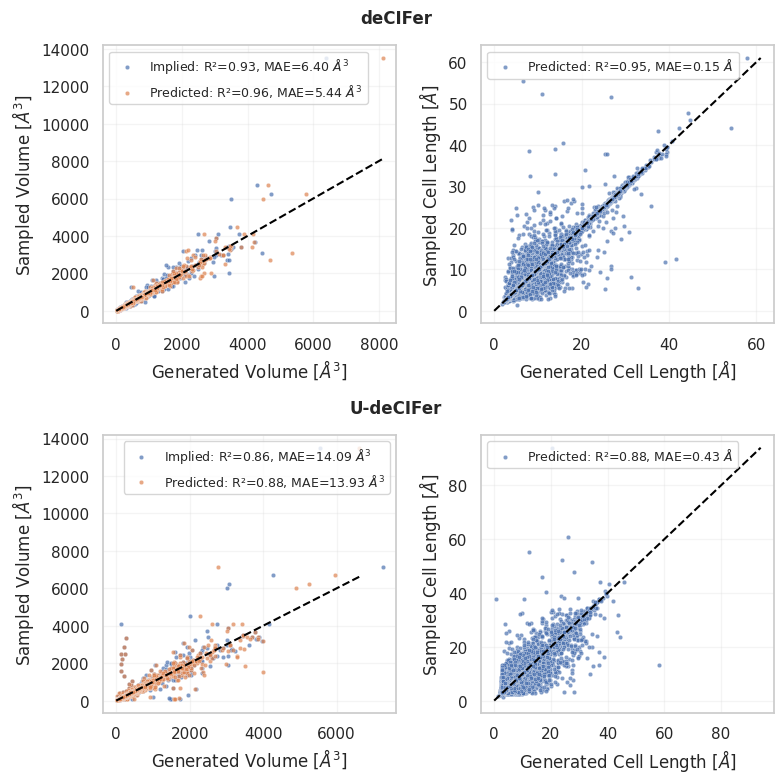

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error

# Define seaborn style
sns.set_theme(style="whitegrid")

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

# R^2 and MAE Analysis functions
def calculate_r2(x, y):
    return r2_score(x, y)

def calculate_mae(x, y):
    return mean_absolute_error(x, y)

# Calculate metrics for deCIFer
r2_implied = calculate_r2(decifer['implied_vol_gen'], decifer['gen_vol_sample'])
mae_implied = calculate_mae(decifer['implied_vol_gen'], decifer['gen_vol_sample'])
r2_predicted = calculate_r2(decifer['gen_vol_gen'], decifer['gen_vol_sample'])
mae_predicted = calculate_mae(decifer['gen_vol_gen'], decifer['gen_vol_sample'])

# Plot 1: deCIFer implied vs. generated volumes
sns.scatterplot(
    x=decifer['implied_vol_gen'], 
    y=decifer['gen_vol_sample'], 
    alpha=0.7, 
    ax=axes[0], 
    label=f"Implied: R²={r2_implied:.2f}, MAE={mae_implied:.2f} $Å^3$",
    s=10,
)
sns.scatterplot(
    x=decifer['gen_vol_gen'], 
    y=decifer['gen_vol_sample'], 
    alpha=0.7, 
    ax=axes[0], 
    label=f"Predicted: R²={r2_predicted:.2f}, MAE={mae_predicted:.2f} $Å^3$",
    s=10,
)
axes[0].plot(
    [0, max(decifer['gen_vol_gen'])], 
    [0, max(decifer['gen_vol_gen'])], 
    c='black', linestyle='--'
)
axes[0].set_xlabel("Generated Volume [$Å^3$]")
axes[0].set_ylabel("Sampled Volume [$Å^3$]")

# Plot 2: Combined deCIFer a, b, c dimensions
r2_3 = calculate_r2(
    np.concatenate([decifer['a_gen'], decifer['b_gen'], decifer['c_gen']]),
    np.concatenate([decifer['a_sample'], decifer['b_sample'], decifer['c_sample']])
)
mae_3 = calculate_mae(
    np.concatenate([decifer['a_gen'], decifer['b_gen'], decifer['c_gen']]),
    np.concatenate([decifer['a_sample'], decifer['b_sample'], decifer['c_sample']])
)

sns.scatterplot(
    x=np.concatenate([decifer['a_gen'], decifer['b_gen'], decifer['c_gen']]),
    y=np.concatenate([decifer['a_sample'], decifer['b_sample'], decifer['c_sample']]),
    alpha=0.7, 
    ax=axes[1],
    s=10,
    label=f"Predicted: R²={r2_3:.2f}, MAE={mae_3:.2f} $Å$",
)
max_2 = max(
    np.nanmax([decifer['a_gen'], decifer['b_gen'], decifer['c_gen']]),
    np.nanmax([decifer['a_sample'], decifer['b_sample'], decifer['c_sample']])
)
axes[1].plot([0, max_2], [0, max_2], c='black', linestyle='--')
axes[1].set_xlabel("Generated Cell Length [$Å$]")
axes[1].set_ylabel("Sampled Cell Length [$Å$]")

# Calculate metrics for U-deCIFer
r2_implied = calculate_r2(udecifer['implied_vol_gen'], udecifer['gen_vol_sample'])
mae_implied = calculate_mae(udecifer['implied_vol_gen'], udecifer['gen_vol_sample'])
r2_predicted = calculate_r2(udecifer['gen_vol_gen'], udecifer['gen_vol_sample'])
mae_predicted = calculate_mae(udecifer['gen_vol_gen'], udecifer['gen_vol_sample'])

# Plot 3: U-deCIFer implied vs. generated volumes
sns.scatterplot(
    x=udecifer['implied_vol_gen'], 
    y=udecifer['gen_vol_sample'], 
    alpha=0.7, 
    ax=axes[2], 
    label=f"Implied: R²={r2_implied:.2f}, MAE={mae_implied:.2f} $Å^3$",
    s=10,
)
sns.scatterplot(
    x=udecifer['gen_vol_gen'], 
    y=udecifer['gen_vol_sample'], 
    alpha=0.7, 
    ax=axes[2], 
    label=f"Predicted: R²={r2_predicted:.2f}, MAE={mae_predicted:.2f} $Å^3$",
    s=10,
)
axes[2].plot(
    [0, max(udecifer['gen_vol_gen'])], 
    [0, max(udecifer['gen_vol_gen'])], 
    c='black', linestyle='--'
)
axes[2].set_xlabel("Generated Volume [$Å^3$]")
axes[2].set_ylabel("Sampled Volume [$Å^3$]")

# Plot 4: Combined U-deCIFer a, b, c dimensions
r2_4 = calculate_r2(
    np.concatenate([udecifer['a_gen'], udecifer['b_gen'], udecifer['c_gen']]),
    np.concatenate([udecifer['a_sample'], udecifer['b_sample'], udecifer['c_sample']])
)
mae_4 = calculate_mae(
    np.concatenate([udecifer['a_gen'], udecifer['b_gen'], udecifer['c_gen']]),
    np.concatenate([udecifer['a_sample'], udecifer['b_sample'], udecifer['c_sample']])
)

sns.scatterplot(
    x=np.concatenate([udecifer['a_gen'], udecifer['b_gen'], udecifer['c_gen']]),
    y=np.concatenate([udecifer['a_sample'], udecifer['b_sample'], udecifer['c_sample']]),
    alpha=0.7, 
    ax=axes[3],
    s=10,
    label=f"Predicted: R²={r2_4:.2f}, MAE={mae_4:.2f} $Å$",
)
max_3 = max(
    np.nanmax([udecifer['a_gen'], udecifer['b_gen'], udecifer['c_gen']]),
    np.nanmax([udecifer['a_sample'], udecifer['b_sample'], udecifer['c_sample']])
)
axes[3].plot([0, max_3], [0, max_3], c='black', linestyle='--')
axes[3].set_xlabel("Generated Cell Length [$Å$]")
axes[3].set_ylabel("Sampled Cell Length [$Å$]")

# # Add titles for rows
# fig.suptitle("deCIFer and U-deCIFer Analysis", fontsize=16, y=1.02)
axes[0].set_title("deCIFer", x=1.0, y=1.05, weight='bold')
axes[2].set_title("U-deCIFer", x=1.0, y=1.05, weight='bold')

# Apply grid and layout
for ax in axes:
    ax.grid(alpha=0.2)
    ax.legend(fontsize=9)

# highlight_box_udecifer = FancyBboxPatch(
#     (0.0, 0.0),  # Bottom-left corner (x, y) in figure-relative coordinates
#     1.0,           # Width
#     0.48,           # Height
#     linewidth=2, edgecolor='k', facecolor='none',
#     boxstyle="round,pad=0.0,rounding_size=0.05",  # Rounded corners
# )
# highlight_box_decifer = FancyBboxPatch(
#     (0.0, 0.51),  # Bottom-left corner (x, y) in figure-relative coordinates
#     1.0,           # Width
#     0.48,           # Height
#     linewidth=2, edgecolor='k', facecolor='none',
#     boxstyle="round,pad=0.0,rounding_size=0.05",  # Rounded corners
# )

    
fig.tight_layout()

# fig.subplots_adjust(hspace=0.3)

# fig.add_artist(highlight_box_decifer)
# fig.add_artist(highlight_box_udecifer)
# 
plt.show()

fig.savefig("cell_parameters_reference_vs_generated.png", transparent=True, bbox_inches='tight')


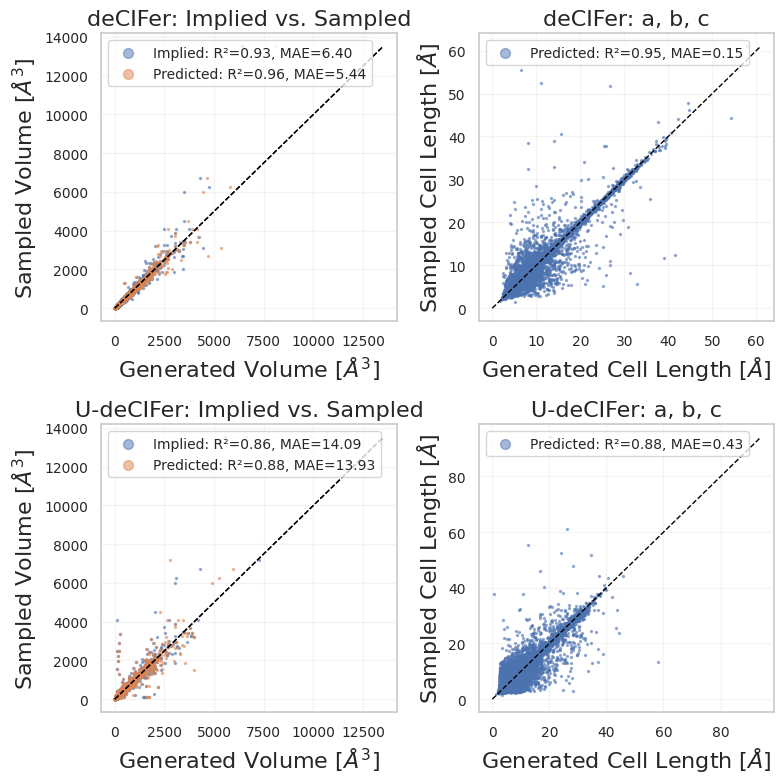

In [287]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib.legend_handler import HandlerPathCollection

# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 16,  # Axes title size
    "axes.labelsize": 16,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 10,  # Y-axis tick labels
    "legend.fontsize": 10,  # Legend font size
})

# Define metrics calculation
def calculate_r2(x, y):
    return r2_score(x, y)

def calculate_mae(x, y):
    return mean_absolute_error(x, y)

# Simplified plotting function
def plot_comparison(ax, x, y, xlabel, ylabel, title, legend_prefix=''):
    r2 = calculate_r2(x, y)
    mae = calculate_mae(x, y)
    ax.scatter(x, y, alpha=0.5, s=2, label=f"{legend_prefix}: R²={r2:.2f}, MAE={mae:.2f}")
    ax.plot([0, max(x.max(), y.max())], [0, max(x.max(), y.max())], color='black', linestyle='--', lw=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(markerscale=5.0)
    ax.grid(alpha=0.2)

# Generate the plots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Plot 1: deCIFer implied vs. generated volumes
plot_comparison(
    axes[0, 0], 
    decifer['implied_vol_gen'], decifer['gen_vol_sample'], 
    "Generated Volume [$Å^3$]", "Sampled Volume [$Å^3$]", 
    "deCIFer: Implied vs. Sampled",
    "Implied"
)
plot_comparison(
    axes[0, 0], 
    decifer['gen_vol_gen'], decifer['gen_vol_sample'], 
    "Generated Volume [$Å^3$]", "Sampled Volume [$Å^3$]", 
    "deCIFer: Implied vs. Sampled",
    "Predicted"
)

# Plot 2: Combined deCIFer a, b, c dimensions
plot_comparison(
    axes[0, 1], 
    np.concatenate([decifer['a_gen'], decifer['b_gen'], decifer['c_gen']]),
    np.concatenate([decifer['a_sample'], decifer['b_sample'], decifer['c_sample']]),
    "Generated Cell Length [$Å$]", "Sampled Cell Length [$Å$]",
    "deCIFer: a, b, c",
    "Predicted",
)

# Plot 3: U-deCIFer implied vs. generated volumes
plot_comparison(
    axes[1, 0], 
    udecifer['implied_vol_gen'], udecifer['gen_vol_sample'], 
    "Generated Volume [$Å^3$]", "Sampled Volume [$Å^3$]", 
    "U-deCIFer: Implied vs. Sampled",
    "Implied",
)
plot_comparison(
    axes[1, 0], 
    udecifer['gen_vol_gen'], udecifer['gen_vol_sample'], 
    "Generated Volume [$Å^3$]", "Sampled Volume [$Å^3$]", 
    "U-deCIFer: Implied vs. Sampled",
    "Predicted",
)

# Plot 4: Combined U-deCIFer a, b, c dimensions
plot_comparison(
    axes[1, 1], 
    np.concatenate([udecifer['a_gen'], udecifer['b_gen'], udecifer['c_gen']]),
    np.concatenate([udecifer['a_sample'], udecifer['b_sample'], udecifer['c_sample']]),
    "Generated Cell Length [$Å$]", "Sampled Cell Length [$Å$]",
    "U-deCIFer: a, b, c",
    "Predicted",
)

# Adjust layout and display
fig.tight_layout()
plt.show()

fig.savefig("cell_parameters_reference_vs_generated.png", transparent=True, bbox_inches='tight', dpi=300)

## Noise levels and broadness levels

In [40]:
from decifer_refactored.utility import generate_continuous_xrd_from_cif, discrete_to_continuous_xrd
import matplotlib.pyplot as plt
import torch

In [289]:
def load(file_path, debug_max=None):
    # Load the data
    with gzip.open(file_path, 'rb') as f:
        df = pd.DataFrame(pickle.load(f))
    
    xrd_q, xrd_iq = [], []
    cifs = []
    for i, entry in df.iterrows():
        if debug_max is not None and (i >= debug_max):
            break
        xrd_q.append(entry['xrd_q_discrete_sample'])
        xrd_iq.append(entry['xrd_q_discrete_sample'])
        cifs.append(entry['cif_sample'])

    return xrd_q, xrd_iq, cifs

# generated using pymatgen
data_CdRhBr2
loop_
 _atom_type_symbol
 _atom_type_electronegativity
 _atom_type_radius
 _atom_type_ionic_radius
  Cd  1.6900  1.5500  1.0900
  Rh  2.2800  1.3500  0.7450
  B


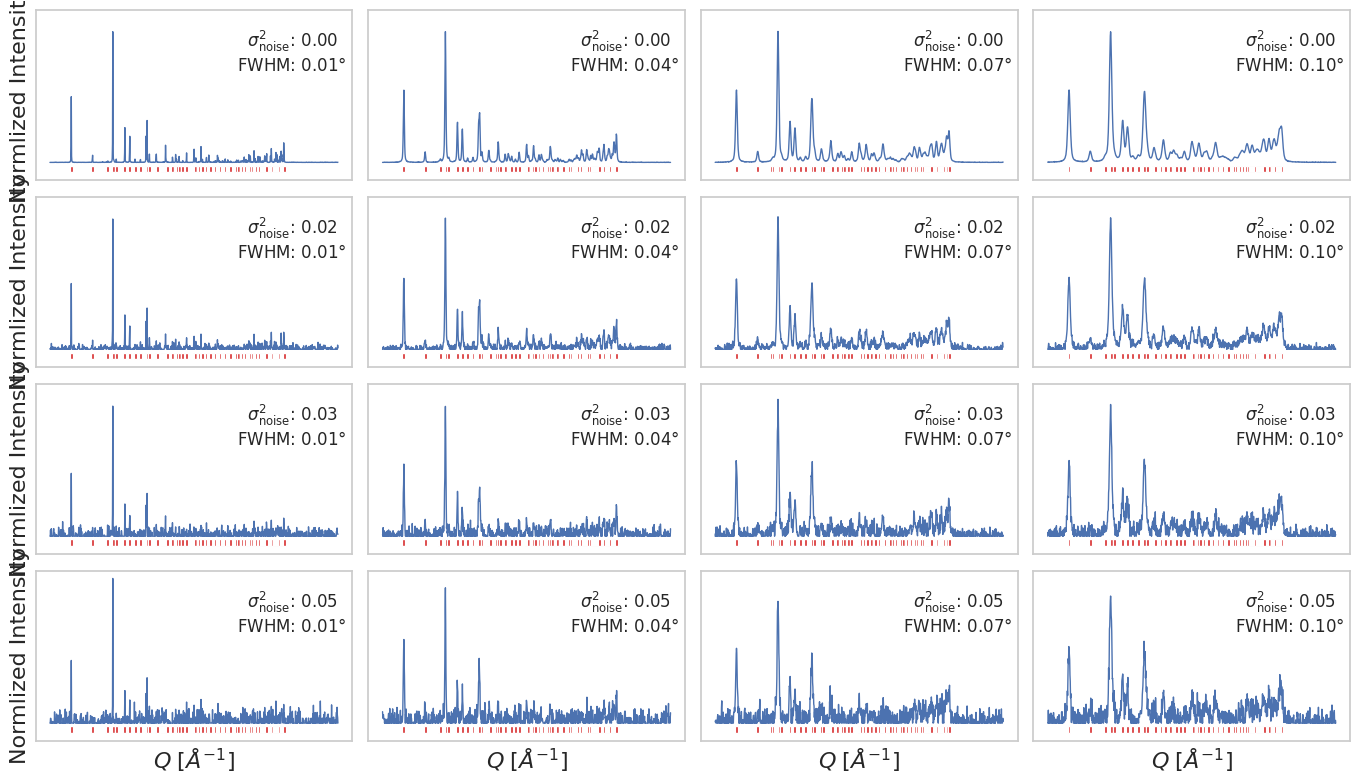

In [290]:
xrd_qs, xrd_iqs, cifs = load(file_path_deCIFer, debug_max=1)
xrd = generate_continuous_xrd_from_cif(
    cifs[0],
    noise_range = None,
    fwhm_range = (0.01, 0.01),
    mask_prob = None,
    intensity_scale_range= None,
) 
xrd_qs = xrd['q_disc']
xrd_iqs = xrd['iq_disc']
num_noise = 4
num_broad = 4

print(cifs[0][:200])

fig, axes = plt.subplots(num_noise,num_broad, figsize=(14,8), sharex=True, sharey=True)

for i, noise in enumerate(np.linspace(0.001, 0.05, num_noise)):
    for j, broad in enumerate(np.linspace(0.01, 0.10, num_broad)):
        xrd = discrete_to_continuous_xrd(
            batch_q = torch.from_numpy(xrd_qs).unsqueeze(0),
            batch_iq = torch.from_numpy(xrd_iqs).unsqueeze(0),
            noise_range = (noise, noise),
            fwhm_range = (broad, broad),
            mask_prob = None,
            intensity_scale_range= None,
        )
        axes[i,j].plot(xrd['q'], xrd['iq'].squeeze(0), lw=1.0)
        axes[i,j].grid(alpha=0.5)
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks([])
        if j == 0:
            axes[i,j].set_ylabel("Normlized Intensity")
        if i == num_broad-1:
            axes[i,j].set_xlabel("$Q\;[Å^{-1}]$")

        axes[i,j].bar(xrd_qs, height=-np.ones_like(xrd_iqs)*0.05, width=0.1, bottom= - 0.025, color='#d62728', label='Bragg Reflections')
        axes[i,j].text(x=6.5, y=.7, s='  $\\sigma_{\\mathrm{noise}}^2$: ' + f'{noise:1.2f}\n' + f'FWHM: {broad:1.2f}$\\degree$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

fig.savefig('noise_broadness.pdf', transparent=True, bbox_inches='tight')

## Generated Examples

In [41]:
import gzip
import pickle
import pandas as pd

from pymatgen.core import Structure
import py3Dmol

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from decifer_refactored.utility import generate_continuous_xrd_from_cif, extract_composition

from tqdm.auto import tqdm

In [42]:
def load_dataframe(file_path):
    """Load DataFrame from a gzipped pickle file."""
    with gzip.open(file_path, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

def extract_structures_and_xrd(row, structure_name='sample', qmax=10.0):
    """Extract structures and generate continuous XRD from a CIF row."""
    cif = row['cif_sample'] if structure_name == 'sample' else row['cif_gen']
    structure = Structure.from_str(cif, fmt="cif")
    xrd = generate_continuous_xrd_from_cif(
        cif,
        qmax=qmax,
        structure_name=structure_name,
        mask_prob=None,
        noise_range=None,
        fwhm_range=(0.05, 0.05)
    )
    return structure, xrd

def plot_xrd_comparison(
    xrd1_sample, 
    xrd1_gen,
    xrd1_sample_disc_q,
    xrd1_sample_disc_iq,
    xrd1_gen_disc_q,
    xrd1_gen_disc_iq,
    xrd2_sample_disc_q,
    xrd2_sample_disc_iq,
    xrd2_gen_disc_q,
    xrd2_gen_disc_iq,
    xrd2_sample, 
    xrd2_gen, 
    title1_sample, 
    title1_gen, 
    title1_diff,
    title2_sample, 
    title2_gen, 
    title2_diff,
    rwp1, 
    wd1, 
    rwp2, 
    wd2, 
    output_file, 
    headroom=None,
    bragg_width=0.1,
    bragg_height=0.5,
):
    """Plot and save XRD comparisons for two datasets."""
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=300)
    m, mm = 900, 100
    
    # First subplot
    ax.plot(xrd1_sample['q'][mm:m], xrd1_sample['iq'][mm:m], lw=2, label=title1_sample)
    ax.plot(xrd1_gen['q'][mm:m], xrd1_gen['iq'][mm:m], lw=1, label=title1_gen)
    ax.plot(xrd1_sample['q'][mm:m], xrd1_sample['iq'][mm:m] - xrd1_gen['iq'][mm:m] - 0.25, label=title1_diff)
    ax.set(xlabel='$Q\;[\AA^{-1}]$', ylabel='Normalized intensity')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=8)
    ax.set_yticks([])
    ax.set_title(f"$R_{{\mathrm{{wp}}}}$: {rwp1:1.4f}, WD: {wd1:1.4f}")

    ax.bar(xrd1_sample_disc_q, height=-np.ones_like(xrd1_sample_disc_iq)*bragg_height, width=bragg_width)
    ax.bar(xrd1_gen_disc_q, height=-np.ones_like(xrd1_gen_disc_iq)*bragg_height, bottom=-bragg_height, width=bragg_width)
    
    # Second subplot
    ax2.plot(xrd2_sample['q'][mm:m], xrd2_sample['iq'][mm:m], lw=2, label=title2_sample)
    ax2.plot(xrd2_gen['q'][mm:m], xrd2_gen['iq'][mm:m], lw=1, label=title2_gen)
    ax2.plot(xrd2_sample['q'][mm:m], xrd2_sample['iq'][mm:m] - xrd2_gen['iq'][mm:m] - 0.25, label=title2_diff)
    ax2.set(xlabel='$Q\;[\AA^{-1}]$', ylabel='Normalized intensity')
    ax2.grid(alpha=0.2)
    ax2.legend(fontsize=8)
    ax2.set_yticks([])
    ax2.set_title(f"$R_{{\mathrm{{wp}}}}$: {rwp2:1.4f}, WD: {wd2:1.4f}")

    ax2.bar(xrd2_sample_disc_q, height=-np.ones_like(xrd2_sample_disc_iq)*bragg_height, width=bragg_width)
    ax2.bar(xrd2_gen_disc_q, height=-np.ones_like(xrd2_gen_disc_iq)*bragg_height, bottom=-bragg_height, width=bragg_width)

    if headroom is not None:
        for axis in [ax, ax2]:
            ymin, ymax = axis.get_ylim()  # Get current y-limits
            new_ymax = ymax + headroom * (ymax - ymin)  # Add proportional headroom
            axis.set_ylim(ymin, new_ymax)  # Set new y-limits
    
    fig.tight_layout()
    plt.show()
    fig.savefig(output_file, transparent=True)

In [141]:
import gzip
import pickle
import pandas as pd
from tqdm import tqdm
from pymatgen.core import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

# Function to generate continuous XRD
def generate_xrd(cif_string, structure_name, qmax=10.0, fwhm_range=(0.05, 0.05)):
    return generate_continuous_xrd_from_cif(
        cif_string,
        qmax=qmax,
        structure_name=structure_name,
        mask_prob=None,
        noise_range=None,
        fwhm_range=fwhm_range
    )

def generate_disc_xrd(cif_string, qmin=0.0, qmax=10.0):

    # Parse the CIF string to get the structure
    structure = Structure.from_str(cif_string, fmt="cif")
    
    # Initialize the XRD calculator using the specified wavelength
    xrd_calculator = XRDCalculator(wavelength='CuKa')
    
    # Calculate the XRD pattern from the structure
    if qmax >= (((4 * np.pi) / xrd_calculator.wavelength) * np.sin(np.radians(180))):
        two_theta_range = None
    else:
        tth_min = 2 * np.arcsin((qmin * xrd_calculator.wavelength) / (4 * np.pi))
        tth_max = 2 * np.arcsin((qmax * xrd_calculator.wavelength) / (4 * np.pi))
        two_theta_range = (tth_min, tth_max)
    xrd_pattern = xrd_calculator.get_pattern(structure, two_theta_range=two_theta_range)

    # Convert 2θ (xrd_pattern.x) to Q (momentum transfer)
    theta_radians = torch.tensor(np.radians(xrd_pattern.x / 2), dtype=torch.float32)
    q_disc = 4 * np.pi * torch.sin(theta_radians) / xrd_calculator.wavelength
    iq_disc = torch.tensor(xrd_pattern.y, dtype=torch.float32)
    
    return q_disc, iq_disc

# --- First File Processing ---
comparison_file_1 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(None_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_1, 'rb') as file:
    comparison_df_1 = pd.DataFrame(pickle.load(file))

# Filter CIFs based on Rwp and space group criteria
for index, row in comparison_df_1.iterrows():
    rwp_1 = row['rwp']
    spacegroup_num = row['spacegroup_num_gen']

    if (rwp_1 < 0.05) and (145 <= spacegroup_num >= 75):
        cif_sample_1 = row['cif_sample']
        cif_generated_1 = row['cif_gen']

        # q_sample_1, iq_sample_1 = row['xrd_q_discrete_sample'], row['xrd_iq_discrete_sample']
        # q_generated_1, iq_generated_1 = row['xrd_q_discrete_gen'], row['xrd_iq_discrete_gen']

        wd_1 = row['wd']
        break

q_sample_1, iq_sample_1 = generate_disc_xrd(cif_sample_1)
q_generated_1, iq_generated_1 = generate_disc_xrd(cif_generated_1)

# Generate XRD profiles for first comparison
xrd_sample_1 = generate_xrd(cif_sample_1, structure_name="sample")
xrd_generated_1 = generate_xrd(cif_generated_1, structure_name="generated")

# --- Second File Processing ---
comparison_file_2 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(Comp_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_2, 'rb') as file:
    comparison_df_2 = pd.DataFrame(pickle.load(file))

# Search for a specific structure and extract CIFs
progress_bar = tqdm(total=len(comparison_df_2), desc="Processing second comparison file")
for index, row in comparison_df_2.iterrows():
    cif_sample_2 = row['cif_sample']
    cif_generated_2 = row['cif_gen']
    
    # q_sample_2, iq_sample_2 = row['xrd_q_discrete_sample'], row['xrd_iq_discrete_sample']
    # q_generated_2, iq_generated_2 = row['xrd_q_discrete_gen'], row['xrd_iq_discrete_gen']
    wd_2 = row['wd']
    rwp_2 = row['rwp']
    
    if cif_sample_2[32:].startswith('CaCd2Ni'):
        break

    progress_bar.update(1)
progress_bar.close()

q_sample_2, iq_sample_2 = generate_disc_xrd(cif_sample_2)
q_generated_2, iq_generated_2 = generate_disc_xrd(cif_generated_2)

# Generate XRD profiles for second comparison
xrd_sample_2 = generate_xrd(cif_sample_2, structure_name="sample")
xrd_generated_2 = generate_xrd(cif_generated_2, structure_name="generated")

# --- Plot Comparison ---
plot_xrd_comparison(
    xrd1_sample=xrd_sample_1,
    xrd1_gen=xrd_generated_1,
    xrd1_sample_disc_q=q_sample_1, 
    xrd1_sample_disc_iq=iq_sample_1,
    xrd1_gen_disc_q=q_generated_1, 
    xrd1_gen_disc_iq=iq_generated_1,
    xrd2_sample=xrd_sample_2,
    xrd2_gen=xrd_generated_2,
    xrd2_sample_disc_q=q_sample_2, 
    xrd2_sample_disc_iq=iq_sample_2,
    xrd2_gen_disc_q=q_generated_2, 
    xrd2_gen_disc_iq=iq_generated_2,
    title1_sample="S",#: CaCd$_2$Ni",
    title1_gen="$S_{\mathrm{none}}^*$",#: Sc$_2$TcBr",
    title1_diff = "$S - S_{\mathrm{none}}^*$",
    title2_sample="S",#"Target: CaCd$_2$Ni",
    title2_gen="$S_{\mathrm{comp}}^*$",#"Generated: CaCd$_2$Ni",
    title2_diff = "$S - S_{\mathrm{comp}}^*$",
    rwp1=rwp_1,
    wd1=wd_1,
    rwp2=rwp_2,
    wd2=wd_2,
    output_file="CaCd2Ni.png",
    bragg_width=0.075,
    bragg_height=.1,
)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [44]:
def plot_xrd_comparison_three(xrd1_sample, xrd1_gen, xrd2_sample, xrd2_gen, xrd3_sample, xrd3_gen, title1_sample, title1_gen, title2_sample, title2_gen, title3_sample, title3_gen, rwp1, wd1, rwp2, wd2, rwp3, wd3, output_file):
    """Plot and save XRD comparisons for two datasets."""
    fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3), dpi=150)
    m, mm = 900, 100
    
    # First subplot
    ax.plot(xrd1_sample['q'][mm:m], xrd1_sample['iq'][mm:m], lw=2, label=title1_sample)
    ax.plot(xrd1_gen['q'][mm:m], xrd1_gen['iq'][mm:m], lw=1, label=title1_gen)
    ax.plot(xrd1_sample['q'][mm:m], xrd1_sample['iq'][mm:m] - xrd1_gen['iq'][mm:m] - 0.1, label='Difference')
    ax.set(xlabel='$Q\;[\AA^{-1}]$', ylabel='Normalized intensity')
    ax.grid(alpha=0.2)
    ax.legend(fontsize=9)
    ax.set_yticks([])
    ax.set_title(f"$R_{{\mathrm{{wp}}}}$: {rwp1:1.4f}, WD: {wd1:1.4f}")
    
    # Second subplot
    ax2.plot(xrd2_sample['q'][mm:m], xrd2_sample['iq'][mm:m], lw=2, label=title2_sample)
    ax2.plot(xrd2_gen['q'][mm:m], xrd2_gen['iq'][mm:m], lw=1, label=title2_gen)
    ax2.plot(xrd2_sample['q'][mm:m], xrd2_sample['iq'][mm:m] - xrd2_gen['iq'][mm:m] - 0.1, label='Difference')
    ax2.set(xlabel='$Q\;[\AA^{-1}]$', ylabel='Normalized intensity')
    ax2.grid(alpha=0.2)
    ax2.legend(fontsize=9)
    ax2.set_yticks([])
    ax2.set_title(f"$R_{{\mathrm{{wp}}}}$: {rwp2:1.4f}, WD: {wd2:1.4f}")

    # Third subplot
    ax3.plot(xrd3_sample['q'][mm:m], xrd3_sample['iq'][mm:m], lw=2, label=title3_sample)
    ax3.plot(xrd3_gen['q'][mm:m], xrd3_gen['iq'][mm:m], lw=1, label=title3_gen)
    ax3.plot(xrd3_sample['q'][mm:m], xrd3_sample['iq'][mm:m] - xrd3_gen['iq'][mm:m] - 0.1, label='Difference')
    ax3.set(xlabel='$Q\;[\AA^{-1}]$', ylabel='Normalized intensity')
    ax3.grid(alpha=0.2)
    ax3.legend(fontsize=9)
    ax3.set_yticks([])
    ax3.set_title(f"$R_{{\mathrm{{wp}}}}$: {rwp3:1.4f}, WD: {wd3:1.4f}")
    
    fig.tight_layout()
    plt.show()
    fig.savefig(output_file, transparent=True)

In [45]:
# Lets find some interesting materials
comparison_file_1 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(None_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_1, 'rb') as file:
    comparison_df_1 = pd.DataFrame(pickle.load(file))

# Filter CIFs based on Rwp and space group criteria
for index, row in comparison_df_1.iterrows():
    comp = extract_composition(row['cif_sample'])
    if len(comp) == 2:
        if "O" in comp.keys():
            print(row['spacegroup_num_gen'])
            print(comp)
            if "Lu" in comp.keys():
                cif_sample_compsg = row['cif_sample']
                cif_generated_comsg = row['cif_gen']
                break


15.0
{'Br': 4.0, 'O': 8.0}
167.0
{'Lu': 12.0, 'O': 18.0}


Processing third comparison file:   4%|█▌                                        | 747/19953 [00:00<00:00, 21679.81it/s]


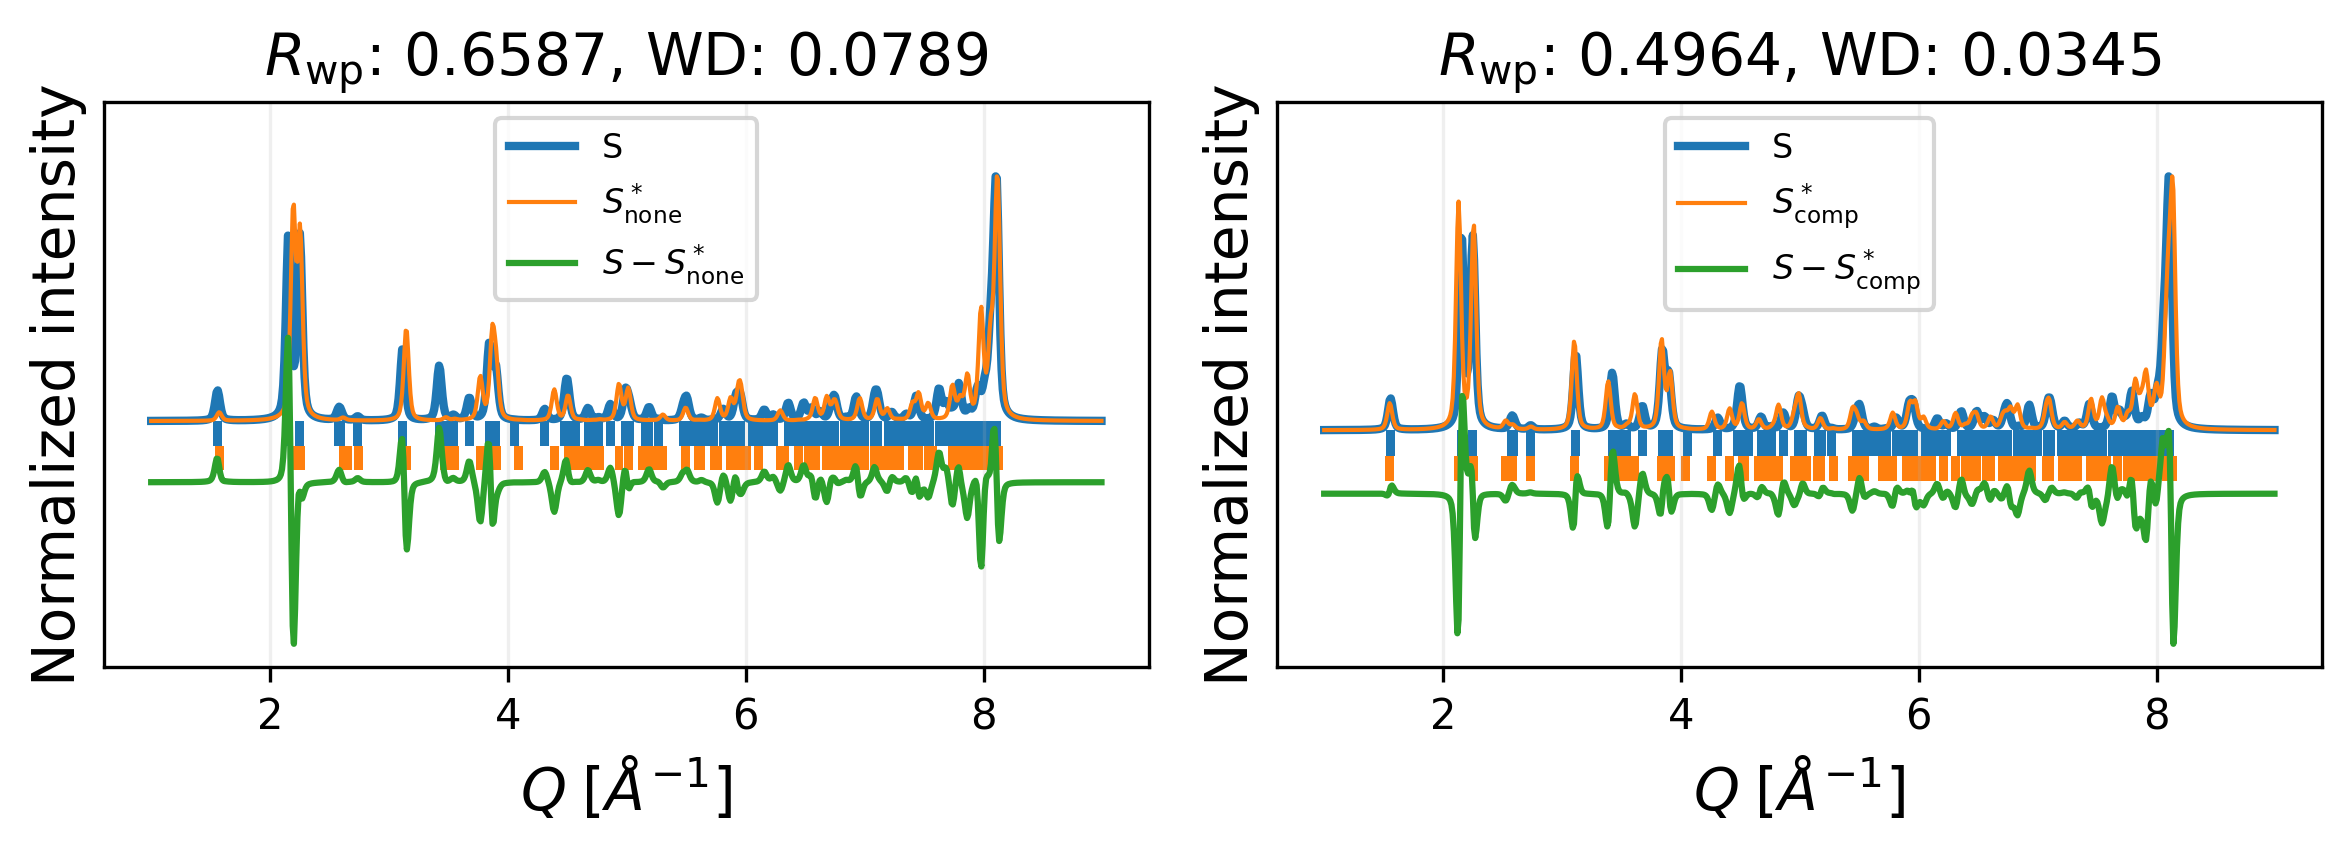

# generated using pymatgen
data_Lu2O3
loop_
 _atom_type_symbol
 _atom_type_electronegativity
 _atom_type_radius
 _atom_type_ionic_radius
  Lu  1.2700  1.7500  1.0010
  O  3.4400  0.6000  1.2600
_symmetry_space_group_name_H-M   R-3c
_cell_length_a   5.5856
_cell_length_b   5.5856
_cell_length_c   14.

data_Sm6W6O18
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Sm 1.1700 1.8500 1.2290
W 2.3600 1.3500 0.7667
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M R-3c
_cell_length_a 5.5790
_cell_length_b 5.5790
_cell_length_c 14.2186
_cell_angle_alpha 

data_Lu12O18
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Lu 1.2700 1.7500 1.0010
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M R-3c
_cell_length_a 5.5689
_cell_length_b 5.5689
_cell_length_c 14.9171
_cell_angle_alpha 90.0000
_cell_angle_beta

data_Lu12O18
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type

In [46]:
import gzip
import pickle
import pandas as pd
from tqdm import tqdm
from pymatgen.core import Structure

# Function to generate continuous XRD
def generate_xrd(cif_string, structure_name, qmax=10.0, fwhm_range=(0.05, 0.05)):
    return generate_continuous_xrd_from_cif(
        cif_string,
        qmax=qmax,
        structure_name=structure_name,
        mask_prob=None,
        noise_range=None,
        fwhm_range=fwhm_range
    )

# --- First File Processing ---
comparison_file_1 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(None_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_1, 'rb') as file:
    comparison_df_1 = pd.DataFrame(pickle.load(file))

# Filter CIFs based on Rwp and space group criteria
for index, row in comparison_df_1.iterrows():
    rwp_1 = row['rwp']
    spacegroup_num = row['spacegroup_num_gen']

    comp = extract_composition(row['cif_sample'])
    if len(comp) == 2:
        if "O" in comp.keys():
            # print(row['spacegroup_num_gen'])
            # print(comp)
            if "Lu" in comp.keys():
                cif_sample_1 = row['cif_sample']
                cif_generated_1 = row['cif_gen']

                wd_1 = row['wd']
                break

q_sample_1, iq_sample_1 = generate_disc_xrd(cif_sample_1)
q_generated_1, iq_generated_1 = generate_disc_xrd(cif_generated_1)

# Generate XRD profiles for first comparison
xrd_sample_1 = generate_xrd(cif_sample_1, structure_name="sample")
xrd_generated_1 = generate_xrd(cif_generated_1, structure_name="generated")

# --- Second File Processing ---
comparison_file_2 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(Comp_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_2, 'rb') as file:
    comparison_df_2 = pd.DataFrame(pickle.load(file))

# Search for a specific structure and extract CIFs
progress_bar = tqdm(total=len(comparison_df_2), desc="Processing second comparison file")
for index, row in comparison_df_2.iterrows():
    cif_sample_2 = row['cif_sample']
    cif_generated_2 = row['cif_gen']
    wd_2 = row['wd']
    rwp_2 = row['rwp']
    
    if cif_sample_2[32:].startswith('Lu2O3'):
        break

    progress_bar.update(1)
progress_bar.close()

q_sample_2, iq_sample_2 = generate_disc_xrd(cif_sample_2)
q_generated_2, iq_generated_2 = generate_disc_xrd(cif_generated_2)

# Generate XRD profiles for second comparison
xrd_sample_2 = generate_xrd(cif_sample_2, structure_name="sample")
xrd_generated_2 = generate_xrd(cif_generated_2, structure_name="generated")

# --- Second File Processing ---
comparison_file_3 = "../experiments/model__conditioned_mlp_augmentation__context_3076/20k_comparison_files/deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz"

with gzip.open(comparison_file_3, 'rb') as file:
    comparison_df_3 = pd.DataFrame(pickle.load(file))

# Search for a specific structure and extract CIFs
progress_bar = tqdm(total=len(comparison_df_3), desc="Processing third comparison file")
for index, row in comparison_df_3.iterrows():
    cif_sample_3 = row['cif_sample']
    cif_generated_3 = row['cif_gen']
    wd_3 = row['wd']
    rwp_3 = row['rwp']
    
    if cif_sample_3[32:].startswith('Lu2O3'):
        break

    progress_bar.update(1)
progress_bar.close()

q_sample_3, iq_sample_3 = generate_disc_xrd(cif_sample_3)
q_generated_3, iq_generated_3 = generate_disc_xrd(cif_generated_3)

# Generate XRD profiles for second comparison
xrd_sample_3 = generate_xrd(cif_sample_3, structure_name="sample")
xrd_generated_3 = generate_xrd(cif_generated_3, structure_name="generated")

# --- Plot Comparison ---
plot_xrd_comparison(
    xrd1_sample=xrd_sample_1,
    xrd1_gen=xrd_generated_1,
    xrd1_sample_disc_q=q_sample_1, 
    xrd1_sample_disc_iq=iq_sample_1,
    xrd1_gen_disc_q=q_generated_1, 
    xrd1_gen_disc_iq=iq_generated_1,
    xrd2_sample=xrd_sample_2,
    xrd2_gen=xrd_generated_2,
    xrd2_sample_disc_q=q_sample_2, 
    xrd2_sample_disc_iq=iq_sample_2,
    xrd2_gen_disc_q=q_generated_2, 
    xrd2_gen_disc_iq=iq_generated_2,
    title1_sample="S",
    title1_gen="$S_{\mathrm{none}}^*$",
    title1_diff = "$S - S_{\mathrm{none}}^*$",
    title2_sample="S",
    title2_gen="$S_{\mathrm{comp}}^*$",
    title2_diff = "$S - S_{\mathrm{comp}}^*$",
    rwp1=rwp_1,
    wd1=wd_1,
    rwp2=rwp_2,
    wd2=wd_2,
    output_file="Lu2O3.png",
    headroom=.1,
    bragg_width=0.075,
    bragg_height=.1,
)

# # --- Plot Comparison ---
# plot_xrd_comparison(
#     xrd1_sample=xrd_sample_1,
#     xrd1_gen=xrd_generated_1,
#     xrd2_sample=xrd_sample_2,
#     xrd2_gen=xrd_generated_2,
#     # xrd3_sample=xrd_sample_3,
#     # xrd3_gen=xrd_generated_3,
#     title1_sample="Target: Lu$_2$O$_3$, R-3c",
#     title1_gen="Generated: SmWO$_3$, R-3c",
#     title2_sample="Target: Lu$_2$O$_3$, R-3c",
#     title2_gen="Generated: Lu$_2$O$_3$, R-3c",
#     # title3_sample="Target: Ge$_2$AuCl, R3m",
#     # title3_gen="Generated: Ge$_2$AuCl, R3m",
#     rwp1=rwp_1,
#     wd1=wd_1,
#     rwp2=rwp_2,
#     wd2=wd_2,
#     # rwp3=rwp_3,
#     # wd3=wd_3,
#     output_file="Lu2O3.png",
#     headroom=.7,
# )

n = 300
print(cif_sample_1[:n])
print()
print(cif_generated_1[:n])
print()
print(cif_generated_2[:n])
print()
print(cif_generated_3[:n])
print()

## Lets make the figures for the violin plots prettier

In [47]:
# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

In [48]:
from bin_refactored.make_comparisons import process
import os
import pandas as pd
import seaborn as sns
COLORS = sns.color_palette()
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.axes import Axes
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib import patheffects
from matplotlib.collections import PolyCollection
from matplotlib.ticker import FuncFormatter
import numpy as np

In [49]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'U-deCIFer (none)': 'deCIFer-U_(None).pkl.gz',
  'deCIFer (none)': 'deCIFer_(None_N-0p00_B-0p05).pkl.gz',
  'U-deCIFer (comp.)': 'deCIFer-U_(Comp).pkl.gz',
  'deCIFer (comp.)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
  'U-deCIFer (comp. & s.g.)': 'deCIFer-U_(CompSG).pkl.gz',
  'deCIFer (comp. & s.g.)': 'deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]
# Prepare the data in long format for efficient plotting
plot_data = []
for metric_key, _ in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        metric_values = data_dict[dataset_label][metric_key].dropna()
        plot_data.extend([
            {'Dataset': dataset_label, 'Metric': metric_key, 'Value': val}
            for val in metric_values
        ])
plot_data = pd.DataFrame(plot_data)

vlines = [1, 3]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 2
x_anchor = 0.5
y_anchor = 1.0

bar_width = 0.25

legend_labels = ['none', 'comp.', 'comp. & s.g.']
ylabels = ['U-deCIFer', 'deCIFer', 'U-deCIFer', 'deCIFer', 'U-deCIFer', 'deCIFer']

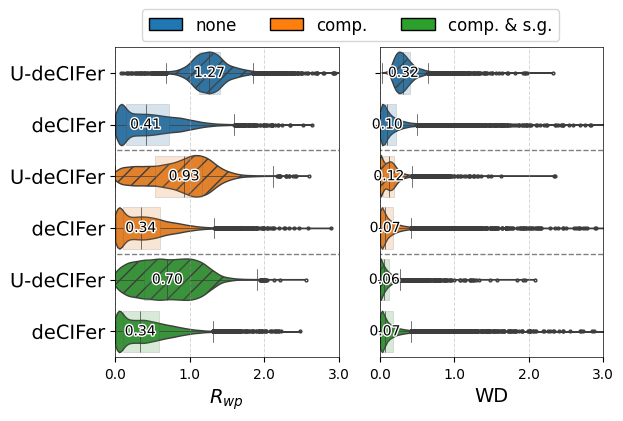

In [50]:
# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

# Generate pairwise colors
colors = COLORS#[3:]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.8  # Aspect ratio (width / height)

# Use Seaborn FacetGrid for multi-metric plotting
g = sns.catplot(
    data=plot_data, 
    x="Value", 
    y="Dataset", 
    hue="Dataset", 
    col="Metric",
    kind="violin", 
    palette=palette, 
    cut=0, 
    linewidth=1.0,
    inner=None,
    sharey=True,
    col_wrap=2,  # Adjust based on number of metrics
    height=height_inches,
    aspect=aspect
)

for ax in g.axes.flat:
    for c in ax.get_children()[::2]:
        if isinstance(c, PolyCollection):
            c.set_hatch("//")
        
# Overlay boxplots and add annotations
for idx, ax in enumerate(g.axes.flat):
    metric_key = metrics_to_plot[idx][0]  # Access individual metric keys
    metric_label = metrics_to_plot[idx][1]      # Access specific y-axis label
    metric_data = plot_data[plot_data["Metric"] == metric_key]
    
    sns.boxplot(
        data=metric_data,
        x="Value",
        y="Dataset",
        palette=palette,
        ax=ax,
        boxprops=dict(alpha=0.2),
        fliersize=2,
        whis=1.5,
        linewidth=0.5
    )

    # Annotate medians
    for i, dataset_label in enumerate(eval_dict.keys()):
        median_value = metric_data[metric_data["Dataset"] == dataset_label]["Value"].median()
        ax.text(
            median_value,
            i,
            f"{median_value:.2f}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            path_effects=[
                path_effects.Stroke(linewidth=2, foreground="white"),
                path_effects.Normal()
            ]
        )
        
    # Optional horizontal reference lines
    if vlines:
        for vline in vlines:
            ax.axhline(xmin=-1.0, y=vline + 0.5, color='gray', linestyle='--', linewidth=1.0)

    # Set individual axis labels
    ax.set_xlabel(metric_label)
    ax.set_ylabel("")
    ax.set_title("")

handles = [
    Patch(facecolor=palette[label], edgecolor='black', label=label) 
    for label in list(eval_dict.keys())[::2]
]

# Add the legend above the entire figure
g.fig.legend(
    handles = handles,
    labels=legend_labels,
    loc='upper center',  # Place legend at the top
    bbox_to_anchor=(0.56, 1.07),  # Center it horizontally above the figure
    ncol=len(legend_labels),  # Put legend in one row
    frameon=True  # Optional: Remove legend box frame
)

# Format x-axis
for ax in g.axes.flat:
    ax.set_xlim(0, 3.0) 
    ax.set_xticks(np.arange(0, 3.1, 1.0)) 
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
    ax.grid(False)#which='minor', alpha=0.01)for idx, ax in enumerate(g.axes.flat):

    # Set custom yticks and labels
    yticks = np.arange(len(ylabels))  # Assuming the number matches datasets
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    # Optional: Style yticklabels for better visibility
    for label in ax.get_yticklabels():
        label.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground="white"),
            path_effects.Normal()
        ])

for ax in g.axes.flat:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)

# Final layout adjustments
g.fig.tight_layout()
plt.show()
g.fig.savefig("baseline_violin_plot_metrics.pdf", transparent=True, bbox_inches='tight', dpi=300)


### CHILI

In [51]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'U-deCIFer (none)': 'deCIFer-U_(None).pkl.gz',

  'deCIFer chili (compN0B5)': 'deCIFer_chili_(Comp_N-0p00_B-0p05).pkl.gz',
  # 'deCIFer chili (compN5B5)': 'deCIFer_chili_(Comp_N-0p05_B-0p05).pkl.gz',
  # 'deCIFer chili (compN0B10)': 'deCIFer_chili_(Comp_N-0p00_B-0p10).pkl.gz',
  'deCIFer chili (compN5B10)': 'deCIFer_chili_(Comp_N-0p05_B-0p10).pkl.gz',
    
  'deCIFer chili (compN10B5)': 'deCIFer_chili_(Comp_N-0p10_B-0p05).pkl.gz',
  'deCIFer chili (compN0B20)': 'deCIFer_chili_(Comp_N-0p00_B-0p20).pkl.gz',
  'deCIFer chili (compN10B20)': 'deCIFer_chili_(Comp_N-0p10_B-0p20).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]
# Prepare the data in long format for efficient plotting
plot_data = []
for metric_key, _ in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        metric_values = data_dict[dataset_label][metric_key].dropna()
        plot_data.extend([
            {'Dataset': dataset_label, 'Metric': metric_key, 'Value': val}
            for val in metric_values
        ])
plot_data = pd.DataFrame(plot_data)


In [52]:
vlines = [0, 2]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 1
x_anchor = 0.5
y_anchor = 1.0

bar_width = 0.25

legend_labels = ['none', 'comp.', 'comp. & s.g.']

ylabels = [
    'U-deCIFer',
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.10', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.10', 

    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.05', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.20', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.20', 
]

ylabels = [
    'U-deCIFer',
    '(0.00, 0.05$\degree$)', 
    '(0.05, 0.10$\degree$)', 
    
    '(0.10, 0.05$\degree$)', 
    '(0.00, 0.20$\degree$)', 
    '(0.10, 0.20$\degree$)', 
]

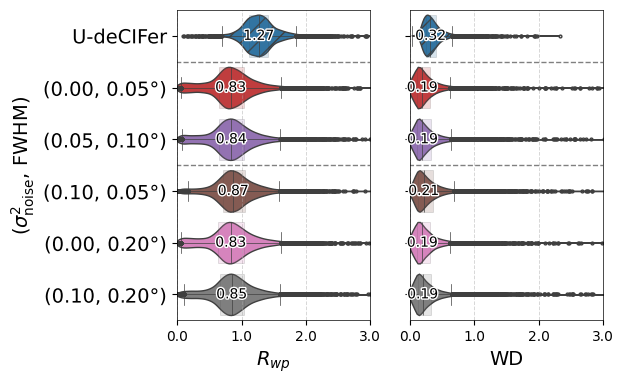

In [53]:
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

# Generate pairwise colors
colors = COLORS[2:]
colors[0] = COLORS[0]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.8  # Aspect ratio (width / height)

# Use Seaborn FacetGrid for multi-metric plotting
g = sns.catplot(
    data=plot_data, 
    x="Value", 
    y="Dataset", 
    hue="Dataset", 
    col="Metric",
    kind="violin", 
    palette=palette, 
    cut=0, 
    linewidth=1.0,
    inner=None,
    sharey=True,
    col_wrap=2,  # Adjust based on number of metrics
    height=height_inches,
    aspect=aspect
)

for ax in g.axes.flat:
    if isinstance(ax.get_children()[0], PolyCollection):
        ax.get_children()[0].set_hatch("//")
        
# Overlay boxplots and add annotations
for idx, ax in enumerate(g.axes.flat):
    metric_key = metrics_to_plot[idx][0]  # Access individual metric keys
    metric_label = metrics_to_plot[idx][1]      # Access specific y-axis label
    metric_data = plot_data[plot_data["Metric"] == metric_key]
    
    sns.boxplot(
        data=metric_data,
        x="Value",
        y="Dataset",
        palette=palette,
        ax=ax,
        boxprops=dict(alpha=0.2),
        fliersize=2,
        whis=1.5,
        linewidth=0.5
    )

    # Annotate medians
    for i, dataset_label in enumerate(eval_dict.keys()):
        median_value = metric_data[metric_data["Dataset"] == dataset_label]["Value"].median()
        ax.text(
            median_value,
            i,
            f"{median_value:.2f}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            path_effects=[
                path_effects.Stroke(linewidth=2, foreground="white"),
                path_effects.Normal()
            ]
        )
        
    # Optional horizontal reference lines
    if vlines:
        for vline in vlines:
            ax.axhline(xmin=-1.0, y=vline + 0.5, color='gray', linestyle='--', linewidth=1.0)

    # Set individual axis labels
    ax.set_xlabel(metric_label)
    ax.set_ylabel("($\sigma_{\mathrm{noise}}^2$, FWHM)")
    ax.set_title("")

handles = [
    Patch(facecolor=palette[label], edgecolor='black', label=label) 
    for label in eval_dict.keys()
]
# print(handles)

# # Add the legend above the entire figure
# g.fig.legend(
#     handles = handles,
#     labels=legend_labels,
#     loc='upper center',  # Place legend at the top
#     bbox_to_anchor=(0.56, 1.05),  # Center it horizontally above the figure
#     ncol=len(legend_labels),  # Put legend in one row
#     frameon=True  # Optional: Remove legend box frame
# )

# Format x-axis
for ax in g.axes.flat:
    ax.set_xlim(0, 3.0) 
    ax.set_xticks(np.arange(0, 3.1, 1.0)) 
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
    ax.grid(False)#which='minor', alpha=0.01)for idx, ax in enumerate(g.axes.flat):

    # Set custom yticks and labels
    yticks = np.arange(len(ylabels))  # Assuming the number matches datasets
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    # Optional: Style yticklabels for better visibility
    for label in ax.get_yticklabels():
        label.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground="white"),
            path_effects.Normal()
        ])

for ax in g.axes.flat:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)

# Final layout adjustments
g.fig.tight_layout()#rect=[0, 0, 1, 0.95])
plt.show()
g.fig.savefig("chili100k_violin_plot_metrics.pdf", transparent=True, bbox_inches='tight', dpi=300)


In [54]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'deCIFer (compN0B5)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
  'deCIFer (compN5B5)': 'deCIFer_(Comp_N-0p05_B-0p05).pkl.gz',
  'deCIFer (compN0B10)': 'deCIFer_(Comp_N-0p00_B-0p10).pkl.gz',
  'deCIFer (compN5B10)': 'deCIFer_(Comp_N-0p05_B-0p10).pkl.gz',
    
  'deCIFer (compN10B5)': 'deCIFer_(Comp_N-0p10_B-0p05).pkl.gz',
  'deCIFer (compN0B20)': 'deCIFer_(Comp_N-0p00_B-0p20).pkl.gz',
  'deCIFer (compN10B20)': 'deCIFer_(Comp_N-0p10_B-0p20).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]
# Prepare the data in long format for efficient plotting
plot_data = []
for metric_key, _ in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        metric_values = data_dict[dataset_label][metric_key].dropna()
        plot_data.extend([
            {'Dataset': dataset_label, 'Metric': metric_key, 'Value': val}
            for val in metric_values
        ])
plot_data = pd.DataFrame(plot_data)

In [55]:
vlines = [3]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 1
skipcolor = 3
x_anchor = 0.5
y_anchor = 1.0

bar_width = 0.25

ylabels = [
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.05', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.05', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.10', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.10', 
    
    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.05', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.20', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.20', 
]
ylabels = [
    '(0.00, 0.05$\degree$)', 
    '(0.05, 0.05$\degree$)', 
    '(0.00, 0.10$\degree$)', 
    '(0.05, 0.10$\degree$)', 
    
    '(0.10, 0.05$\degree$)', 
    '(0.00, 0.20$\degree$)', 
    '(0.10, 0.20$\degree$)', 
]

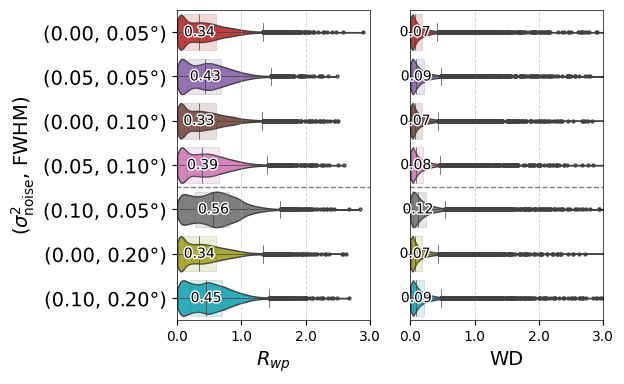

In [56]:
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 14,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 14,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

# Generate pairwise colors
colors = COLORS[skipcolor:]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.8  # Aspect ratio (width / height)

# Use Seaborn FacetGrid for multi-metric plotting
g = sns.catplot(
    data=plot_data, 
    x="Value", 
    y="Dataset", 
    hue="Dataset", 
    col="Metric",
    kind="violin", 
    palette=palette, 
    cut=0, 
    linewidth=1.0,
    inner=None,
    sharey=True,
    col_wrap=2,  # Adjust based on number of metrics
    height=height_inches,
    aspect=aspect
)

# Overlay boxplots and add annotations
for idx, ax in enumerate(g.axes.flat):
    metric_key = metrics_to_plot[idx][0]  # Access individual metric keys
    metric_label = metrics_to_plot[idx][1]      # Access specific y-axis label
    metric_data = plot_data[plot_data["Metric"] == metric_key]
    
    sns.boxplot(
        data=metric_data,
        x="Value",
        y="Dataset",
        palette=palette,
        ax=ax,
        boxprops=dict(alpha=0.2),
        fliersize=2,
        whis=1.5,
        linewidth=0.5
    )

    # Annotate medians
    for i, dataset_label in enumerate(eval_dict.keys()):
        median_value = metric_data[metric_data["Dataset"] == dataset_label]["Value"].median()
        ax.text(
            median_value,
            i,
            f"{median_value:.2f}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            path_effects=[
                path_effects.Stroke(linewidth=2, foreground="white"),
                path_effects.Normal()
            ]
        )
        
    # Optional horizontal reference lines
    if vlines:
        for vline in vlines:
            ax.axhline(xmin=-1.0, y=vline + 0.5, color='gray', linestyle='--', linewidth=1.0)

    # Set individual axis labels
    ax.set_xlabel(metric_label)
    ax.set_ylabel("($\sigma_{\mathrm{noise}}^2$, FWHM)")
    ax.set_title("")

# Format x-axis
for ax in g.axes.flat:
    ax.set_xlim(0, 3.0) 
    ax.set_xticks(np.arange(0, 3.1, 1.0)) 
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
    ax.grid(False)

    # Set custom yticks and labels
    yticks = np.arange(len(ylabels))  # Assuming the number matches datasets
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, rotation=0)

    # Optional: Style yticklabels for better visibility
    for label in ax.get_yticklabels():
        label.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground="white"),
            path_effects.Normal()
        ])

for ax in g.axes.flat:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)

# Final layout adjustments
g.fig.tight_layout()

plt.show()
g.fig.savefig("robustness_violin_plot_metrics.pdf", transparent=True, bbox_inches='tight')


In [57]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'deCIFer (none)': 'deCIFer_(None_N-0p00_B-0p05).pkl.gz',
  'deCIFer (comp.)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
  'deCIFer (comp. & s.g.)': 'deCIFer_(CompSG_N-0p00_B-0p05).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]

# Mapping spacegroup numbers to crystal systems
spacegroup_to_crystal_system = {
    'Triclinic': range(1, 3),
    'Monoclinic': range(3, 16),
    'Orthorhombic': range(16, 75),
    'Tetragonal': range(75, 143),
    'Trigonal': range(143, 168),
    'Hexagonal': range(168, 195),
    'Cubic': range(195, 231)
}

# Define crystal system order
crystal_system_order = [
    "Cubic",
    "Hexagonal",
    "Trigonal",
    "Tetragonal",
    "Orthorhombic",
    "Monoclinic",
    "Triclinic",
]

# Function to map spacegroup number to its corresponding crystal system
def get_crystal_system(spacegroup_number):
    try:
        sg_number = int(spacegroup_number)
        for system, sg_range in spacegroup_to_crystal_system.items():
            if sg_number in sg_range:
                return system
        return 'Unknown'
    except (ValueError, TypeError):
        return 'Unknown'
        
crystal_systems = list(spacegroup_to_crystal_system.keys())

In [58]:
from decifer_refactored.utility import space_group_symbol_to_number

plot_data = []
for metric_key, metric_label in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        data = data_dict[dataset_label]
        for idx, row in data.iterrows():
            spacegroup = row.get("spacegroup_sym_sample", None)  # Adjust key if needed
            spacegroup = space_group_symbol_to_number(spacegroup)
            if spacegroup is None:
                print(row['spacegroup_sym_sample'])
            spacegroup_gen = row.get("spacegroup_num_gen", None)  # Adjust key if needed
            crystal_system = get_crystal_system(spacegroup)
            crystal_system_gen = get_crystal_system(spacegroup_gen)
            value = row.get(metric_key, None)
            if pd.notna(value):
                plot_data.append({
                    'Dataset': dataset_label,
                    'Metric': metric_label,
                    'Value': value,
                    'Crystal System': crystal_system,
                    'Crystal System Gen': crystal_system_gen,
                })
plot_data = pd.DataFrame(plot_data)
plot_data['Crystal System'] = pd.Categorical(
    plot_data['Crystal System'],
    categories=crystal_system_order,
    ordered=True,
)
# Add Data-Size Distribution column
data_size_distribution = (
    plot_data.groupby('Crystal System')
    .size()
    .reset_index(name='Data Size')
)
plot_data = plot_data.merge(
    data_size_distribution, 
    on='Crystal System', 
    how='left'
)
# Custom y-axis labels
dataset_labels = {
    'deCIFer (none)': "none",
    'deCIFer (comp.)': "comp.",
    'deCIFer (comp. & s.g.)': "comp. & s.g.",
}
plot_data['Dataset Label'] = plot_data['Dataset'].map(dataset_labels)

# Compute the data size for each crystal system and dataset
data_size_distribution = (
    plot_data.groupby(['Crystal System', 'Dataset'])
    .size()
    .reset_index(name='Value')
)
data_size_distribution['Metric'] = "Sample\nDistribution"

# Concatenate the new data with the existing plot_data
plot_data = pd.concat([plot_data, data_size_distribution], ignore_index=True)


plot_data

,Dataset,Metric,Value,Crystal System,Crystal System Gen,Data Size,Dataset Label
0,deCIFer (none),$R_{wp}$,0.408133,Trigonal,Trigonal,10094.0,none
1,deCIFer (none),$R_{wp}$,0.747770,Orthorhombic,Orthorhombic,27360.0,none
2,deCIFer (none),$R_{wp}$,0.914195,Triclinic,Monoclinic,782.0,none
3,deCIFer (none),$R_{wp}$,0.277484,Cubic,Cubic,36444.0,none
4,deCIFer (none),$R_{wp}$,1.501433,Tetragonal,Tetragonal,23012.0,none
...,...,...,...,...,...,...,...
119628,deCIFer (comp.),Sample\nDistribution,5672.000000,Monoclinic,NaN,NaN,NaN
119629,deCIFer (none),Sample\nDistribution,5680.000000,Monoclinic,NaN,NaN,NaN
119630,deCIFer (comp. & s.g.),Sample\nDistribution,252.000000,Triclinic,NaN,NaN,NaN
119631,deCIFer (comp.),Sample\nDistribution,264.000000,Triclinic,NaN,NaN,NaN


In [59]:
vlines = [1, 3]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 1
x_anchor = 0.5
y_anchor = 1.0
skipcolor = 0

bar_width = 0.25

legend_labels = ['none', 'comp.', 'comp. & s.g.']
ylabels = ['deCIFer','deCIFer', 'deCIFer']

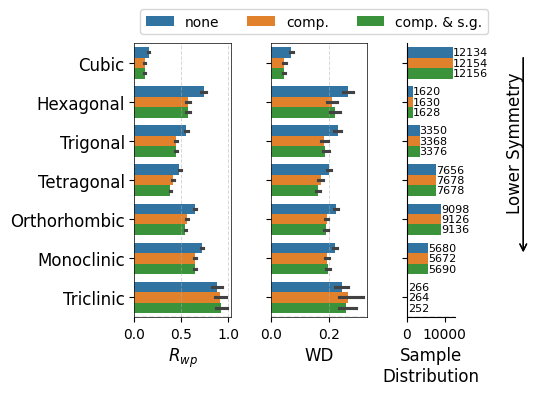

In [60]:
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 14,  # Axes title size
    "axes.labelsize": 12,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 12,  # Y-axis tick labels
    "legend.fontsize": 10,  # Legend font size
})
# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.5  # Aspect ratio (width / height)

# Generate pairwise colors
colors = COLORS[skipcolor:]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

g = sns.catplot(
    data=plot_data,
    x="Value",
    y="Crystal System",
    hue="Dataset",
    col="Metric",
    kind="bar",
    palette=palette,
    sharey=True,
    sharex=False,
    col_wrap=3,
    height=height_inches,
    aspect=aspect,
    order=crystal_system_order,  # Enforce the predefined order,
    edgecolor='none'
)

# Use metric names for x-axis labels dynamically
g.set_axis_labels("", "")  # Clear default labels
for ax, col_value in zip(g.axes.flat, plot_data['Metric'].unique()):
    ax.set_xlabel(col_value)  # Set metric name as x-axis label

g.set_titles("")

# Manually adjust
pos = g.axes.flat[-1].get_position() 
new_pos = [pos.x0, pos.y0, pos.width * 0.5, pos.height * 1.0]  # Example adjustments
g.axes.flat[-1].set_position(new_pos)

# Extract handles and labels from the legend
labels, handles = g._legend_data.keys(), g._legend_data.values()
g._legend.remove()  # Remove the default legend from the subplots

labels = ['none', 'comp.', 'comp. & s.g.']

# Add the legend above the entire figure
g.fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',  # Place legend at the top
    bbox_to_anchor=(0.5, 0.95),  # Center it horizontally above the figure
    ncol=len(labels),  # Put legend in one row
    frameon=True  # Optional: Remove legend box frame
)

last_ax = g.axes.flat[-1]

# Iterate through the bars and add text above each one
for i, bar in enumerate(last_ax.patches):  # 'patches' contains all the bar rectangles
    # Get the height of the bar (value of the bar)
    bar_value = bar.get_width()
    if bar_value < 1:
        break
    
    # Get the x and y position of the bar
    bar_y = bar.get_y() + bar.get_height() / 2  # Center the text horizontally
    bar_x = bar.get_x()  # Position text above the bar
    
    # Add the text annotation
    last_ax.text(
        x = bar_x + bar_value, 
        y = bar_y,  # Slightly above the bar
        s = f'{int(bar_value)}',  # Format value to 2 decimal places
        ha='left',  # Horizontal alignment
        va='center',  # Vertical alignment
        fontsize=8,  # Font size
        color='black'  # Text color
    )

# Ensure full axes box for all axes
for ax in g.axes.flat[:-1]:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)
g.axes.flat[-1].grid(False)

arrow_x = 0.65
g.fig.add_artist(
    plt.annotate(
        '',  # No text for the arrow itself
        xy=(arrow_x, 0.35),  # Arrowhead position in normalized figure coordinates
        xytext=(arrow_x, 0.85),  # Arrow tail position in normalized figure coordinates
        xycoords='figure fraction',
        textcoords='figure fraction',
        arrowprops=dict(facecolor='black', arrowstyle='->', color='k'),
    )
)
g.fig.text(
    0.75, 0.6,  # X and Y positions in figure coordinates
    'Lower Symmetry',
    ha='center',
    va='center',
    transform=g.fig.transFigure,
    rotation='vertical',
)

g.fig.axes[0].set_xticks(np.linspace(0,1,3))

for ax in g.fig.axes:
    ax.axhline(xmin=0, y=6 + 0.5, color='gray', linestyle='--', linewidth=1.0)

plt.show()

g.fig.savefig("baseline_crystal_systems_metrics.pdf", transparent=True, bbox_inches='tight', dpi=300)


In [61]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'deCIFer chili (compN0B5)': 'deCIFer_chili_(Comp_N-0p00_B-0p05).pkl.gz',
  'deCIFer chili (compN10B20)': 'deCIFer_chili_(Comp_N-0p10_B-0p20).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]

# Mapping spacegroup numbers to crystal systems
spacegroup_to_crystal_system = {
    'Triclinic': range(1, 3),
    'Monoclinic': range(3, 16),
    'Orthorhombic': range(16, 75),
    'Tetragonal': range(75, 143),
    'Trigonal': range(143, 168),
    'Hexagonal': range(168, 195),
    'Cubic': range(195, 231)
}

# Define crystal system order
crystal_system_order = [
    "Cubic",
    "Hexagonal",
    "Trigonal",
    "Tetragonal",
    "Orthorhombic",
    "Monoclinic",
    "Triclinic",
]

# Function to map spacegroup number to its corresponding crystal system
def get_crystal_system(spacegroup_number):
    try:
        sg_number = int(spacegroup_number)
        for system, sg_range in spacegroup_to_crystal_system.items():
            if sg_number in sg_range:
                return system
        return 'Unknown'
    except (ValueError, TypeError):
        return 'Unknown'
        
crystal_systems = list(spacegroup_to_crystal_system.keys())

In [62]:
plot_data = []
for metric_key, metric_label in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        data = data_dict[dataset_label]
        for idx, row in data.iterrows():
            spacegroup = row.get("spacegroup_sym_sample", None)  # Adjust key if needed
            spacegroup = space_group_symbol_to_number(spacegroup)
            spacegroup_gen = row.get("spacegroup_num_sample", None)  # Adjust key if needed
            crystal_system = get_crystal_system(spacegroup)
            crystal_system_gen = get_crystal_system(spacegroup_gen)
            value = row.get(metric_key, None)
            if pd.notna(value):
                plot_data.append({
                    'Dataset': dataset_label,
                    'Metric': metric_label,
                    'Value': value,
                    'Crystal System': crystal_system,
                    'Crystal System Gen': crystal_system_gen,
                })
plot_data = pd.DataFrame(plot_data)
plot_data['Crystal System'] = pd.Categorical(
    plot_data['Crystal System'],
    categories=crystal_system_order,
    ordered=True,
)
# Add Data-Size Distribution column
data_size_distribution = (
    plot_data.groupby('Crystal System')
    .size()
    .reset_index(name='Data Size')
)
plot_data = plot_data.merge(
    data_size_distribution, 
    on='Crystal System', 
    how='left'
)
# Custom y-axis labels
dataset_labels = {
    'deCIFer (none)': "none",
    'deCIFer (comp.)': "comp.",
    'deCIFer (comp. & s.g.)': "comp. & s.g.",
}
plot_data['Dataset Label'] = plot_data['Dataset'].map(dataset_labels)

# Compute the data size for each crystal system and dataset
data_size_distribution = (
    plot_data.groupby(['Crystal System', 'Dataset'])
    .size()
    .reset_index(name='Value')
)
data_size_distribution['Metric'] = "Sample\nDistribution"

# Concatenate the new data with the existing plot_data
plot_data = pd.concat([plot_data, data_size_distribution], ignore_index=True)


plot_data

,Dataset,Metric,Value,Crystal System,Crystal System Gen,Data Size,Dataset Label
0,deCIFer chili (compN0B5),$R_{wp}$,0.779793,Orthorhombic,Unknown,11508.0,NaN
1,deCIFer chili (compN0B5),$R_{wp}$,0.690255,Orthorhombic,Unknown,11508.0,NaN
2,deCIFer chili (compN0B5),$R_{wp}$,0.913459,Hexagonal,Unknown,4216.0,NaN
3,deCIFer chili (compN0B5),$R_{wp}$,0.726728,Tetragonal,Tetragonal,6094.0,NaN
4,deCIFer chili (compN0B5),$R_{wp}$,1.250560,Orthorhombic,Orthorhombic,11508.0,NaN
...,...,...,...,...,...,...,...
69749,deCIFer chili (compN10B20),Sample\nDistribution,6458.000000,Orthorhombic,NaN,NaN,NaN
69750,deCIFer chili (compN0B5),Sample\nDistribution,7644.000000,Monoclinic,NaN,NaN,NaN
69751,deCIFer chili (compN10B20),Sample\nDistribution,9894.000000,Monoclinic,NaN,NaN,NaN
69752,deCIFer chili (compN0B5),Sample\nDistribution,8182.000000,Triclinic,NaN,NaN,NaN


In [63]:
vlines = [3]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 1
skipcolor = 0
x_anchor = 0.5
y_anchor = 1.0

bar_width = 0.25


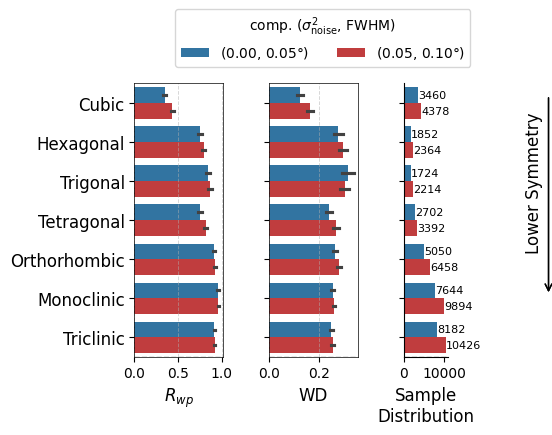

In [64]:
# Generate pairwise colors
colors = COLORS[skipcolor::3]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 12,  # Axes title size
    "axes.labelsize": 12,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 12,  # Y-axis tick labels
    "legend.fontsize": 10,  # Legend font size
    "legend.title_fontsize": 10,  # Legend font size
})
# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.5  # Aspect ratio (width / height)

g = sns.catplot(
    data=plot_data,
    x="Value",
    y="Crystal System",
    hue="Dataset",
    col="Metric",
    kind="bar",
    palette=palette,
    sharey=True,
    sharex=False,
    col_wrap=3,
    height=height_inches,
    aspect=aspect,
    order=crystal_system_order,
    edgecolor='none'
)

# Use metric names for x-axis labels dynamically
g.set_axis_labels("", "")  # Clear default labels
for ax, col_value in zip(g.axes.flat, plot_data['Metric'].unique()):
    ax.set_xlabel(col_value)  # Set metric name as x-axis label

g.set_titles("")

# Manually adjust
pos = g.axes.flat[-1].get_position() 
new_pos = [pos.x0, pos.y0, pos.width * 0.5, pos.height * 1.0]  # Example adjustments
g.axes.flat[-1].set_position(new_pos)

# Extract handles and labels from the legend
labels, handles = g._legend_data.keys(), g._legend_data.values()
g._legend.remove()  # Remove the default legend from the subplots


labels = [
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.10', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.10', 
    
    # '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.20', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.20', 
]

labels = [
    '(0.00, 0.05$\degree$)', 
    '(0.05, 0.10$\degree$)', 
    '(0.10, 0.20)$\degree$', 
]

# Add the legend above the entire figure
g.fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',  # Place legend at the top
    bbox_to_anchor=(0.5, 1.05),  # Center it horizontally above the figure
    ncol=len(labels),  # Put legend in one row
    frameon=True,  # Optional: Remove legend box frame
    title='comp. ($\sigma_{\mathrm{noise}}^2$, FWHM)'
)

last_ax = g.axes.flat[-1]

# Iterate through the bars and add text above each one
for i, bar in enumerate(last_ax.patches):  # 'patches' contains all the bar rectangles
    # Get the height of the bar (value of the bar)
    bar_value = bar.get_width()
    if bar_value < 1:
        break
    
    # Get the x and y position of the bar
    bar_y = bar.get_y() + bar.get_height() / 2  # Center the text horizontally
    bar_x = bar.get_x()  # Position text above the bar
    
    # Add the text annotation
    last_ax.text(
        x = bar_x + bar_value, 
        y = bar_y,  # Slightly above the bar
        s = f'{int(bar_value)}',  # Format value to 2 decimal places
        ha='left',  # Horizontal alignment
        va='center',  # Vertical alignment
        fontsize=8,  # Font size
        color='black'  # Text color
    )

# Ensure full axes box for all axes
for ax in g.axes.flat[:-1]:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)
g.axes.flat[-1].grid(False)

arrow_x = 0.65
g.fig.add_artist(
    plt.annotate(
        '',  # No text for the arrow itself
        xy=(arrow_x, 0.35),  # Arrowhead position in normalized figure coordinates
        xytext=(arrow_x, 0.85),  # Arrow tail position in normalized figure coordinates
        xycoords='figure fraction',
        textcoords='figure fraction',
        arrowprops=dict(facecolor='black', arrowstyle='->', color='k'),
    )
)
g.fig.text(
    0.75, 0.6,  # X and Y positions in figure coordinates
    'Lower Symmetry',
    ha='center',
    va='center',
    transform=g.fig.transFigure,
    rotation='vertical',
)

for ax in g.fig.axes:
    ax.axhline(xmin=0, y=6 + 0.5, color='gray', linestyle='--', linewidth=1.0)

g.fig.axes[0].set_xticks(np.linspace(0,1,3))

plt.show()

g.fig.savefig("chili_crystal_systems_metrics.pdf", transparent=True, bbox_inches='tight')


In [65]:
experiment_folder = '../experiments/model__conditioned_mlp_augmentation__context_3076/comparison_files_fullXRD/'
debug_max = None

eval_dict = {
  'deCIFer (compN0B5)': 'deCIFer_(Comp_N-0p00_B-0p05).pkl.gz',
  # 'deCIFer (compN5B5)': 'deCIFer_(Comp_N-0p05_B-0p05).pkl.gz',
  # 'deCIFer (compN0B10)': 'deCIFer_(Comp_N-0p00_B-0p10).pkl.gz',
  'deCIFer (compN5B10)': 'deCIFer_(Comp_N-0p05_B-0p10).pkl.gz',
    
  # 'deCIFer (compN10B5)': 'deCIFer_(Comp_N-0p10_B-0p05).pkl.gz',
  # 'deCIFer (compN0B20)': 'deCIFer_(Comp_N-0p00_B-0p20).pkl.gz',
  'deCIFer (compN10B20)': 'deCIFer_(Comp_N-0p10_B-0p20).pkl.gz',
}

data_dict = {}
for label, path in eval_dict.items():
    # Determine if the path is a pickle or a folder
    full_path = os.path.join(experiment_folder, path)
    data_dict[label] = pd.read_pickle(full_path)

metrics_to_plot = [
    ('rwp', r"$R_{wp}$"),
    ('wd', "WD"),
]

# Mapping spacegroup numbers to crystal systems
spacegroup_to_crystal_system = {
    'Triclinic': range(1, 3),
    'Monoclinic': range(3, 16),
    'Orthorhombic': range(16, 75),
    'Tetragonal': range(75, 143),
    'Trigonal': range(143, 168),
    'Hexagonal': range(168, 195),
    'Cubic': range(195, 231)
}

# Define crystal system order
crystal_system_order = [
    "Cubic",
    "Hexagonal",
    "Trigonal",
    "Tetragonal",
    "Orthorhombic",
    "Monoclinic",
    "Triclinic",
]

# Function to map spacegroup number to its corresponding crystal system
def get_crystal_system(spacegroup_number):
    try:
        sg_number = int(spacegroup_number)
        for system, sg_range in spacegroup_to_crystal_system.items():
            if sg_number in sg_range:
                return system
        return 'Unknown'
    except (ValueError, TypeError):
        return 'Unknown'
        
crystal_systems = list(spacegroup_to_crystal_system.keys())

In [66]:
plot_data = []
for metric_key, metric_label in metrics_to_plot:
    for dataset_label in eval_dict.keys():
        data = data_dict[dataset_label]
        for idx, row in data.iterrows():
            spacegroup = row.get("spacegroup_sym_sample", None)  # Adjust key if needed
            spacegroup = space_group_symbol_to_number(spacegroup)
            spacegroup_gen = row.get("spacegroup_num_sample", None)  # Adjust key if needed
            crystal_system = get_crystal_system(spacegroup)
            crystal_system_gen = get_crystal_system(spacegroup_gen)
            value = row.get(metric_key, None)
            if pd.notna(value):
                plot_data.append({
                    'Dataset': dataset_label,
                    'Metric': metric_label,
                    'Value': value,
                    'Crystal System': crystal_system,
                    'Crystal System Gen': crystal_system_gen,
                })
plot_data = pd.DataFrame(plot_data)
plot_data['Crystal System'] = pd.Categorical(
    plot_data['Crystal System'],
    categories=crystal_system_order,
    ordered=True,
)
# Add Data-Size Distribution column
data_size_distribution = (
    plot_data.groupby('Crystal System')
    .size()
    .reset_index(name='Data Size')
)
plot_data = plot_data.merge(
    data_size_distribution, 
    on='Crystal System', 
    how='left'
)
# Custom y-axis labels
dataset_labels = {
    'deCIFer (none)': "none",
    'deCIFer (comp.)': "comp.",
    'deCIFer (comp. & s.g.)': "comp. & s.g.",
}
plot_data['Dataset Label'] = plot_data['Dataset'].map(dataset_labels)

# Compute the data size for each crystal system and dataset
data_size_distribution = (
    plot_data.groupby(['Crystal System', 'Dataset'])
    .size()
    .reset_index(name='Value')
)
data_size_distribution['Metric'] = "Sample\nDistribution"

# Concatenate the new data with the existing plot_data
plot_data = pd.concat([plot_data, data_size_distribution], ignore_index=True)


plot_data

,Dataset,Metric,Value,Crystal System,Crystal System Gen,Data Size,Dataset Label
0,deCIFer (compN0B5),$R_{wp}$,0.337821,Trigonal,Trigonal,10120.0,NaN
1,deCIFer (compN0B5),$R_{wp}$,0.989223,Orthorhombic,Orthorhombic,27394.0,NaN
2,deCIFer (compN0B5),$R_{wp}$,1.084355,Triclinic,Triclinic,780.0,NaN
3,deCIFer (compN0B5),$R_{wp}$,0.233349,Cubic,Cubic,36460.0,NaN
4,deCIFer (compN0B5),$R_{wp}$,0.273819,Tetragonal,Tetragonal,23022.0,NaN
...,...,...,...,...,...,...,...
119716,deCIFer (compN10B20),Sample\nDistribution,5680.000000,Monoclinic,NaN,NaN,NaN
119717,deCIFer (compN5B10),Sample\nDistribution,5696.000000,Monoclinic,NaN,NaN,NaN
119718,deCIFer (compN0B5),Sample\nDistribution,264.000000,Triclinic,NaN,NaN,NaN
119719,deCIFer (compN10B20),Sample\nDistribution,264.000000,Triclinic,NaN,NaN,NaN


In [67]:
vlines = [3]

legend_ncol_crystal_system = 3
legend_ncol_validity = 3
color_pair_size = 1
skipcolor = 3
x_anchor = 0.5
y_anchor = 1.0

bar_width = 0.25


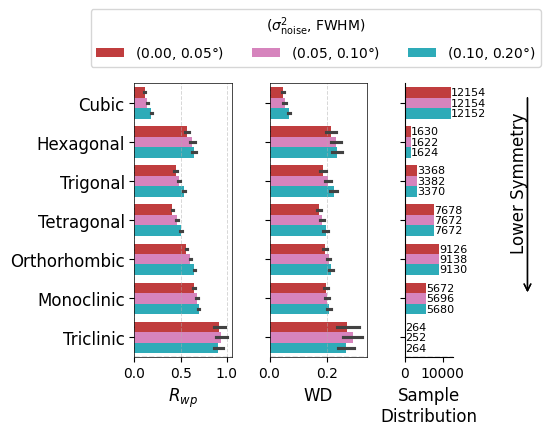

In [68]:
# Generate pairwise colors
colors = COLORS[skipcolor::3]
dataset_colors = [colors[i // color_pair_size % len(colors)] for i in range(len(eval_dict.keys()))]
palette = {label: dataset_colors[i] for i, label in enumerate(eval_dict.keys())}  # Corrected here

plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 12,  # Axes title size
    "axes.labelsize": 12,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 12,  # Y-axis tick labels
    "legend.fontsize": 10,  # Legend font size
    "legend.title_fontsize": 10,  # Legend font size
})
# Desired figure height in pixels
height_pixels = 1200
# DPI (dots per inch)
dpi = 300

# Convert pixel height to inches
height_inches = height_pixels / dpi

# Adjust the aspect ratio as needed for the figure's width
aspect = 0.5  # Aspect ratio (width / height)

g = sns.catplot(
    data=plot_data,
    x="Value",
    y="Crystal System",
    hue="Dataset",
    col="Metric",
    kind="bar",
    palette=palette,
    sharey=True,
    sharex=False,
    col_wrap=3,
    height=height_inches,
    aspect=aspect,
    order=crystal_system_order,
    edgecolor='none',
)

# Use metric names for x-axis labels dynamically
g.set_axis_labels("", "")  # Clear default labels
for ax, col_value in zip(g.axes.flat, plot_data['Metric'].unique()):
    ax.set_xlabel(col_value)  # Set metric name as x-axis label

g.set_titles("")

# Manually adjust
pos = g.axes.flat[-1].get_position() 
new_pos = [pos.x0, pos.y0, pos.width * 0.5, pos.height * 1.0]  # Example adjustments
g.axes.flat[-1].set_position(new_pos)

# Extract handles and labels from the legend
labels, handles = g._legend_data.keys(), g._legend_data.values()
g._legend.remove()  # Remove the default legend from the subplots


labels = [
    '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.10', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.05\nFWHM = 0.10', 
    
    # '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.05', 
    # '$\sigma_{\mathrm{noise}}^2$ = 0.00\nFWHM = 0.20', 
    '$\sigma_{\mathrm{noise}}^2$ = 0.10\nFWHM = 0.20', 
]

labels = [
    '(0.00, 0.05$\degree$)', 
    '(0.05, 0.10$\degree$)', 
    '(0.10, 0.20$\degree$)', 
]

# Add the legend above the entire figure
g.fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',  # Place legend at the top
    bbox_to_anchor=(0.5, 1.05),  # Center it horizontally above the figure
    ncol=len(labels),  # Put legend in one row
    frameon=True,
    title='($\sigma_{\mathrm{noise}}^2$, FWHM)'
)

last_ax = g.axes.flat[-1]

# Iterate through the bars and add text above each one
for i, bar in enumerate(last_ax.patches):  # 'patches' contains all the bar rectangles
    # Get the height of the bar (value of the bar)
    bar_value = bar.get_width()
    if bar_value < 1:
        break
    
    # Get the x and y position of the bar
    bar_y = bar.get_y() + bar.get_height() / 2  # Center the text horizontally
    bar_x = bar.get_x()  # Position text above the bar
    
    # Add the text annotation
    last_ax.text(
        x = bar_x + bar_value, 
        y = bar_y,  # Slightly above the bar
        s = f'{int(bar_value)}',  # Format value to 2 decimal places
        ha='left',  # Horizontal alignment
        va='center',  # Vertical alignment
        fontsize=8,  # Font size
        color='black'  # Text color
    )

# Ensure full axes box for all axes
for ax in g.axes.flat[:-1]:
    for spine in ax.spines.values():
        spine.set_visible(True)  # Make all spines visible
        spine.set_linewidth(0.5)  # Optional: Adjust border thickness
    ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.5)

g.axes.flat[-1].grid(False)

arrow_x = 0.65
g.fig.add_artist(
    plt.annotate(
        '',  # No text for the arrow itself
        xy=(arrow_x, 0.35),  # Arrowhead position in normalized figure coordinates
        xytext=(arrow_x, 0.85),  # Arrow tail position in normalized figure coordinates
        xycoords='figure fraction',
        textcoords='figure fraction',
        arrowprops=dict(facecolor='black', arrowstyle='->', color='k'),
    )
)
g.fig.text(
    0.75, 0.6,  # X and Y positions in figure coordinates
    'Lower Symmetry',
    ha='center',
    va='center',
    transform=g.fig.transFigure,
    rotation='vertical',
)

for ax in g.fig.axes:
    ax.axhline(xmin=0, y=6 + 0.5, color='gray', linestyle='--', linewidth=1.0)

g.fig.axes[0].set_xticks(np.linspace(0,1,3))

plt.show()

g.fig.savefig("robustness_crystal_systems_metrics.pdf", transparent=True, bbox_inches='tight')


## PCA on XRD embeddings

In [19]:
import numpy as np
import pandas as pd
import torch

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from decifer_refactored.decifer_dataset import DeciferDataset
from decifer_refactored.decifer_model import Decifer, DeciferConfig
from decifer_refactored.tokenizer import Tokenizer
from bin_refactored.evaluate import extract_prompt, load_model_from_checkpoint
from decifer_refactored.utility import (
    replace_symmetry_loop_with_P1,
    extract_space_group_symbol,
    reinstate_symmetry_loop,
    discrete_to_continuous_xrd,
    generate_continuous_xrd_from_cif,
    space_group_symbol_to_number,
    extract_volume,
    extract_numeric_property,
    element_to_atomic_number,
    space_group_to_crystal_system,
)

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
tokenizer = Tokenizer()

# load a cif string and its xrd
dataset = DeciferDataset('../data/crystallm/full/serialized/train.h5', ['cif_string', 'cif_tokens', 'xrd.q', 'xrd.iq', 'spacegroup', 'species'])

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_model_from_checkpoint('../experiments/model__conditioned_mlp_augmentation__context_3076/ckpt.pt', device)
model.eval();
cond_embedder = model.transformer.cond_embedding

number of total parameters: 26.14M


In [69]:
debug_max = 500_000

cif_strings, space_groups, avg_elements, max_elements, volumes, log_volumes, embeddings = [], [], [], [], [], [], []
sum_elements, cell_a, cell_b, cell_c, cell_alpha, cell_beta, cell_gamma = [], [], [], [], [], [], []

pbar = tqdm(total=min(debug_max,len(dataset)) if debug_max else len(dataset))
for i, datum in enumerate(iter(dataset)):
    if debug_max and (i >= debug_max):
        break

    # Extract information
    xrd_disc_q = datum['xrd.q']
    xrd_disc_iq = datum['xrd.iq']
    cif_string = datum['cif_string']
    space_group = space_group_symbol_to_number(datum['spacegroup'])
    volume = extract_volume(cif_string)
    log_volume = np.log10(volume)
    elements = [element_to_atomic_number(e) for e in list(datum['species'].split('"')[1::2])]
    avg_element = np.mean(elements, axis=0)
    max_element = np.max(elements, axis=0)
    sum_element = np.sum(elements, axis=0)
    a = extract_numeric_property(cif_string, '_cell_length_a')
    b = extract_numeric_property(cif_string, '_cell_length_b')
    c = extract_numeric_property(cif_string, '_cell_length_c')
    alpha = extract_numeric_property(cif_string, '_cell_angle_alpha')
    beta = extract_numeric_property(cif_string, '_cell_angle_beta')
    gamma = extract_numeric_property(cif_string, '_cell_angle_gamma')

    # Simulate XRD and embed:
    iq = discrete_to_continuous_xrd(
        xrd_disc_q.unsqueeze(0),
        xrd_disc_iq.unsqueeze(0),
        qmin = 0.0,
        qmax = 10.0,
        qstep = 0.01,
        fwhm_range = (0.05, 0.05),
        noise_range = None,
        mask_prob=None,
        intensity_scale_range=None
    )['iq'].squeeze(0).to(device=model.device)
    with torch.no_grad():
        embedding = cond_embedder(iq)

    # Append
    cif_strings.append(cif_string)
    space_groups.append(space_group)
    avg_elements.append(avg_element)
    max_elements.append(max_element)
    sum_elements.append(sum_element)
    volumes.append(volume)
    cell_a.append(a)
    cell_b.append(b)
    cell_c.append(c)
    cell_alpha.append(alpha)
    cell_beta.append(beta)
    cell_gamma.append(gamma)
    log_volumes.append(log_volume)
    embeddings.append(embedding)
    pbar.update(1)
pbar.close()

embeddings_stacked = torch.vstack(embeddings).cpu().numpy()
space_groups = np.array(space_groups, dtype=float)
avg_elements = np.array(avg_elements, dtype=float)
max_elements = np.array(max_elements, dtype=float)
sum_elements = np.array(sum_elements, dtype=float)
cell_a = np.array(cell_a, dtype=float)
cell_b = np.array(cell_b, dtype=float)
cell_c = np.array(cell_c, dtype=float)
cell_alpha = np.array(cell_alpha, dtype=float)
cell_beta = np.array(cell_beta, dtype=float)
cell_gamma = np.array(cell_gamma, dtype=float)
volumes = np.array(volumes, dtype=float)
log_volumes = np.array(log_volumes, dtype=float)

100%|██████████████████████████████████████████████████████████████████████████| 500000/500000 [17:45<00:00, 469.19it/s]


In [74]:
pca = PCA(n_components=3)
pca_results = pca.fit_transform(embeddings_stacked)

In [75]:
df = pd.DataFrame({
    'PC1': pca_results[:, 0],
    'PC2': pca_results[:, 1],
    'PC3': pca_results[:, 2],
    'Spacegroup': space_groups,  # Ensure numeric values
    'Avg Element': avg_elements,
    'Max Element': max_elements,
    'Crystal System': [space_group_to_crystal_system(s) for s in space_groups],
    'Avg Element Spacegroup': space_groups.astype(float) + avg_elements,
    'Sum Element': sum_elements,
    'Volume': volumes,
    'Log Volume': log_volumes,
    'Cell A': cell_a,
    'Cell B': cell_b,
    'Cell C': cell_c,
    'Cell Alpha': cell_alpha,
    'Cell Beta': cell_beta,
    'Cell Gamma': cell_gamma,
})

# Define the mapping from numerical values to categorical names
crystal_system_mapping = {
    0: "Unknown",
    1: "Triclinic",
    2: "Monoclinic",
    3: "Orthorhombic",
    4: "Tetragonal",
    5: "Trigonal",
    6: "Hexagonal",
    7: "Cubic"
}

# Ensure the 'Crystal System' column is numeric
df['Crystal System'] = df['Crystal System'].astype(int)  # Ensure integers

# Map the numerical values to names
df['Crystal System'] = df['Crystal System'].map(crystal_system_mapping)

# Convert the column to a categorical type
df['Crystal System'] = pd.Categorical(
    df['Crystal System'],
    categories=list(crystal_system_mapping.values()),
    ordered=True
)

In [76]:
df

,PC1,PC2,PC3,Spacegroup,Avg Element,Max Element,Crystal System,Avg Element Spacegroup,Sum Element,Volume,Log Volume,Cell A,Cell B,Cell C,Cell Alpha,Cell Beta,Cell Gamma
0,-0.065269,0.036788,-0.189186,65.0,43.000000,80.0,Orthorhombic,108.000000,129.0,112.8804,2.052619,3.0853,7.5690,4.8337,90.0,90.0000,90.0
1,0.023628,0.020643,0.007297,166.0,42.666667,76.0,Trigonal,208.666667,128.0,227.9461,2.357832,3.1015,3.1015,27.3622,90.0,90.0000,120.0
2,0.022278,-0.213006,0.038529,216.0,27.000000,45.0,Cubic,243.000000,81.0,385.8053,2.586368,7.2799,7.2799,7.2799,90.0,90.0000,90.0
3,-0.063963,-0.151089,0.067601,44.0,26.333333,30.0,Orthorhombic,70.333333,79.0,191.0607,2.281171,3.6335,5.0418,10.4293,90.0,90.0000,90.0
4,-0.150544,-0.020312,-0.083433,225.0,39.500000,66.0,Cubic,264.500000,79.0,320.4735,2.505792,6.8433,6.8433,6.8433,90.0,90.0000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.062656,0.103260,0.109414,99.0,47.666667,76.0,Tetragonal,146.666667,143.0,93.4229,1.970453,3.1316,3.1316,9.5265,90.0,90.0000,90.0
499996,0.024990,0.105872,-0.005318,6.0,47.666667,56.0,Monoclinic,53.666667,143.0,108.3394,2.034786,3.4840,3.5588,8.7572,90.0,93.8066,90.0
499997,0.077497,0.061205,-0.140221,225.0,59.666667,80.0,Cubic,284.666667,179.0,335.9792,2.526312,6.9519,6.9519,6.9519,90.0,90.0000,90.0
499998,-0.082455,0.087640,-0.103741,65.0,31.000000,57.0,Orthorhombic,96.000000,93.0,180.0845,2.255476,4.2783,5.7647,7.3016,90.0,90.0000,90.0


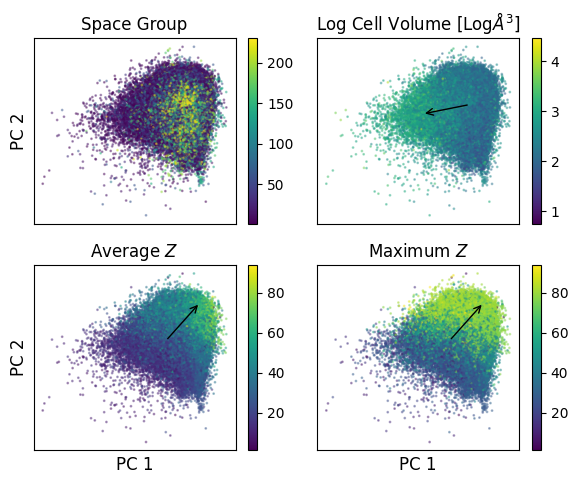

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({
    "font.size": 12,  # Global font size
    "axes.titlesize": 12,  # Axes title size
    "axes.labelsize": 12,  # Axes label size
    "xtick.labelsize": 10,  # X-axis tick labels
    "ytick.labelsize": 10,  # Y-axis tick labels
    "legend.fontsize": 12,  # Legend font size
})

# Debug max
debug_max = 1000000

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(6, 5), sharex=True, sharey=True)
axes = axes.ravel()

# Define the colorings and labels
colorings = ['Spacegroup', 'Log Volume', 'Avg Element', 'Max Element']#, 'Sum Element', 'Cell A', 'Cell B', 'Cell C', 'Cell Alpha', 'Cell Beta', 'Cell Gamma']
labels = ['Space Group', 'Log Cell Volume [Log$Å^3$]', 'Average $Z$', 'Maximum $Z$']#, 'Sum Element', 'Cell A', 'Cell B', 'Cell C', 'Cell Alpha', 'Cell Beta', 'Cell Gamma']

# Define arrow coordinates for each plot (start_x, start_y, end_x, end_y)
arrow_coords = [
    ((0.1, 0.1), (0.3, 0.3)),  # Arrow for the first subplot
    ((0.0, -0.0), (-0.7, -0.1)),  # Arrow for the second subplot
    ((-0.3, -0.1), (0.2, 0.3)),  # Arrow for the third subplot
    ((-0.3, -0.1), (0.2, 0.3)),   # Arrow for the fourth subplot
]

# Plot each PCA scatter plot
for i, (coloring, label) in enumerate(zip(colorings, labels)):
    scatter = axes[i].scatter(
        df['PC1'][:debug_max], 
        df['PC2'][:debug_max], 
        c=df[coloring][:debug_max], 
        cmap='viridis', 
        s=1, 
        alpha=0.4,
    )
    axes[i].set_title(label)
    axes[i].set_xlabel('PC 1' if i in [2, 3] else '')
    axes[i].set_ylabel('PC 2' if i in [0, 2] else '')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    # Add an arrow to the plot
    if i > 0:
        start, end = arrow_coords[i]
        axes[i].annotate(
            '', 
            xy=end, 
            xytext=start, 
            arrowprops=dict(facecolor='red', arrowstyle='->', lw=1)
        )

    # Add a colorbar without alpha by creating a mappable object
    norm = scatter.norm  # Reuse the scatter's normalization
    cmap = scatter.cmap  # Reuse the scatter's colormap
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for ScalarMappable to work with colorbar

    # Add colorbar to the plot
    cbar = fig.colorbar(sm, ax=axes[i], shrink=1.0)
    cbar.ax.tick_params(labelsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

fig.savefig("pca_train500k.png", transparent=True, bbox_inches='tight', dpi=300)


### Data distribution

In [122]:
import h5py
from tqdm.auto import tqdm
from decifer_refactored.utility import (
    generate_continuous_xrd_from_cif,
    extract_numeric_property,
    get_unit_cell_volume,
    extract_volume,
    space_group_symbol_to_number,
    element_to_atomic_number,
    extract_formula_nonreduced,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pymatgen.core import Composition

In [127]:
data_paths =  [
    '../data/crystallm/full/serialized/train.h5',
    '../data/crystallm/full/serialized/val.h5',
    '../data/crystallm/full/serialized/test.h5',
    '../data/chili100k/full/serialized/train.h5',
    '../data/chili100k/full/serialized/val.h5',
    '../data/chili100k/full/serialized/test.h5',
]

debug_max = 100
data = []

for data_path in data_paths:
    with h5py.File(data_path, 'r') as f:
    
        num_files = min(debug_max, len(f['cif_name'])) if debug_max else len(f['cif_name'])
        
        pbar = tqdm(total=num_files, desc='Extracting data')
        for i in range(num_files):
    
            # Extract data
            cif_name = f['cif_name'][i].decode("utf-8")
            comp = Composition(extract_formula_nonreduced(f['cif_string'][i].decode("utf-8"))).reduced_composition.as_dict()
            species = list(comp.keys())
            # print(comp.items())
            
            spacegroup_num = space_group_symbol_to_number(f['spacegroup'][i].decode("utf-8"))
            #species = list(f['species'][i].decode("utf-8").split('"')[1::2])
            atomic_numbers = [element_to_atomic_number(e)*n for e,n in comp.items()]
    
            # Collect
            datum = {
                'cif_name': cif_name,
                'spacegroup_num': spacegroup_num,
                'species': species,
                'atomic_numbers': atomic_numbers,
                'num_elements': len(species),
            }
            
            if cif_name.startswith('NOMAD'):
                datum['dataset'] = 'NOMAD'
            elif cif_name.startswith('OQMD'):
                datum['dataset'] = 'OQMD'
            elif cif_name.startswith('MP'):
                datum['dataset'] = 'MP'
            else:
                datum['dataset'] = 'CHILI-100K'
            data.append(datum)
            pbar.update(1)
        pbar.close()

# data_path = '../data/chili100k/full/serialized/test.h5'
# debug_max = 10000

# with h5py.File(data_path, 'r') as f:

#     num_files = min(debug_max, len(f['cif_name'])) if debug_max else len(f['cif_name'])
    
#     pbar = tqdm(total=num_files, desc='Extracting data')
#     for i in range(num_files):

#         # Extract data
#         cif_name = f['cif_name'][i].decode("utf-8")
#         spacegroup_num = space_group_symbol_to_number(f['spacegroup'][i].decode("utf-8"))
#         species = list(f['species'][i].decode("utf-8").split('"')[1::2])
#         atomic_numbers = [element_to_atomic_number(e) for e in species]

#         # Collect
#         datum = {
#             'cif_name': cif_name,
#             'spacegroup_num': spacegroup_num,
#             'species': species,
#             'atomic_numbers': atomic_numbers,
#             'datagroup': 'CHILI-100K',
#             'dataset': 'CHILI-100K',
#             'num_elements': len(species),
#         }
#         data.append(datum)
#         pbar.update(1)
#     pbar.close()

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting data:   0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
data_df = pd.DataFrame(data)

# Unwrap the 'atomic_numbers' column
exploded_df = data_df.explode(['species', 'atomic_numbers'], ignore_index=True)

# Ensure the unwrapped column is of integer type
exploded_df["atomic_numbers"] = exploded_df["atomic_numbers"].astype(int)
exploded_df["species"] = exploded_df["species"].astype(str)

# Create the sorted order for species based on atomic numbers, ensuring uniqueness
species_order = (
    exploded_df[['species', 'atomic_numbers']]
    .drop_duplicates()
    .sort_values('atomic_numbers')['species']
    .unique()
)

species_order = np.array(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg',
       'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V',
       'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se',
       'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh',
       'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba',
       'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho',
       'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt',
       'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac',
       'Th', 'Pa', 'U', 'Np', 'Pu', 'Am'], dtype=object)

species_order_labels = np.array([
    'H (1)', 'He (2)', 'Li (3)', 'Be (4)', 'B (5)', 'C (6)', 'N (7)', 'O (8)', 'F (9)', 'Ne (10)',
    'Na (11)', 'Mg (12)', 'Al (13)', 'Si (14)', 'P (15)', 'S (16)', 'Cl (17)', 'Ar (18)', 
    'K (19)', 'Ca (20)', 'Sc (21)', 'Ti (22)', 'V (23)', 'Cr (24)', 'Mn (25)', 'Fe (26)', 
    'Co (27)', 'Ni (28)', 'Cu (29)', 'Zn (30)', 'Ga (31)', 'Ge (32)', 'As (33)', 'Se (34)', 
    'Br (35)', 'Kr (36)', 'Rb (37)', 'Sr (38)', 'Y (39)', 'Zr (40)', 'Nb (41)', 'Mo (42)', 
    'Tc (43)', 'Ru (44)', 'Rh (45)', 'Pd (46)', 'Ag (47)', 'Cd (48)', 'In (49)', 'Sn (50)', 
    'Sb (51)', 'Te (52)', 'I (53)', 'Xe (54)', 'Cs (55)', 'Ba (56)', 'La (57)', 'Ce (58)', 
    'Pr (59)', 'Nd (60)', 'Pm (61)', 'Sm (62)', 'Eu (63)', 'Gd (64)', 'Tb (65)', 'Dy (66)', 
    'Ho (67)', 'Er (68)', 'Tm (69)', 'Yb (70)', 'Lu (71)', 'Hf (72)', 'Ta (73)', 'W (74)', 
    'Re (75)', 'Os (76)', 'Ir (77)', 'Pt (78)', 'Au (79)', 'Hg (80)', 'Tl (81)', 'Pb (82)', 
    'Bi (83)', 'Po (84)', 'At (85)', 'Rn (86)', 'Fr (87)', 'Ra (88)', 'Ac (89)', 'Th (90)', 
    'Pa (91)', 'U (92)', 'Np (93)', 'Pu (94)', 'Am (95)'], dtype=object)


# Convert species to a categorical type with the desired order
exploded_df['species'] = pd.Categorical(exploded_df['species'], categories=species_order, ordered=True)

In [129]:
exploded_df

,cif_name,spacegroup_num,species,atomic_numbers,num_elements,dataset
0,NOMAD_ZDB6c1X37DXHoHoUPxxWmrGKijTp,65,Hg,80,3,NOMAD
1,NOMAD_ZDB6c1X37DXHoHoUPxxWmrGKijTp,65,B,10,3,NOMAD
2,NOMAD_ZDB6c1X37DXHoHoUPxxWmrGKijTp,65,Ru,44,3,NOMAD
3,NOMAD_dP5MP2rFgeW5UBEiHOFTEEmIOcpV,166,Y,39,3,NOMAD
4,NOMAD_dP5MP2rFgeW5UBEiHOFTEEmIOcpV,166,Al,26,3,NOMAD
...,...,...,...,...,...,...
2032,4513483.cif,4,H,20,6,CHILI-100K
2033,4513483.cif,4,C,102,6,CHILI-100K
2034,4513483.cif,4,Br,35,6,CHILI-100K
2035,4513483.cif,4,N,14,6,CHILI-100K


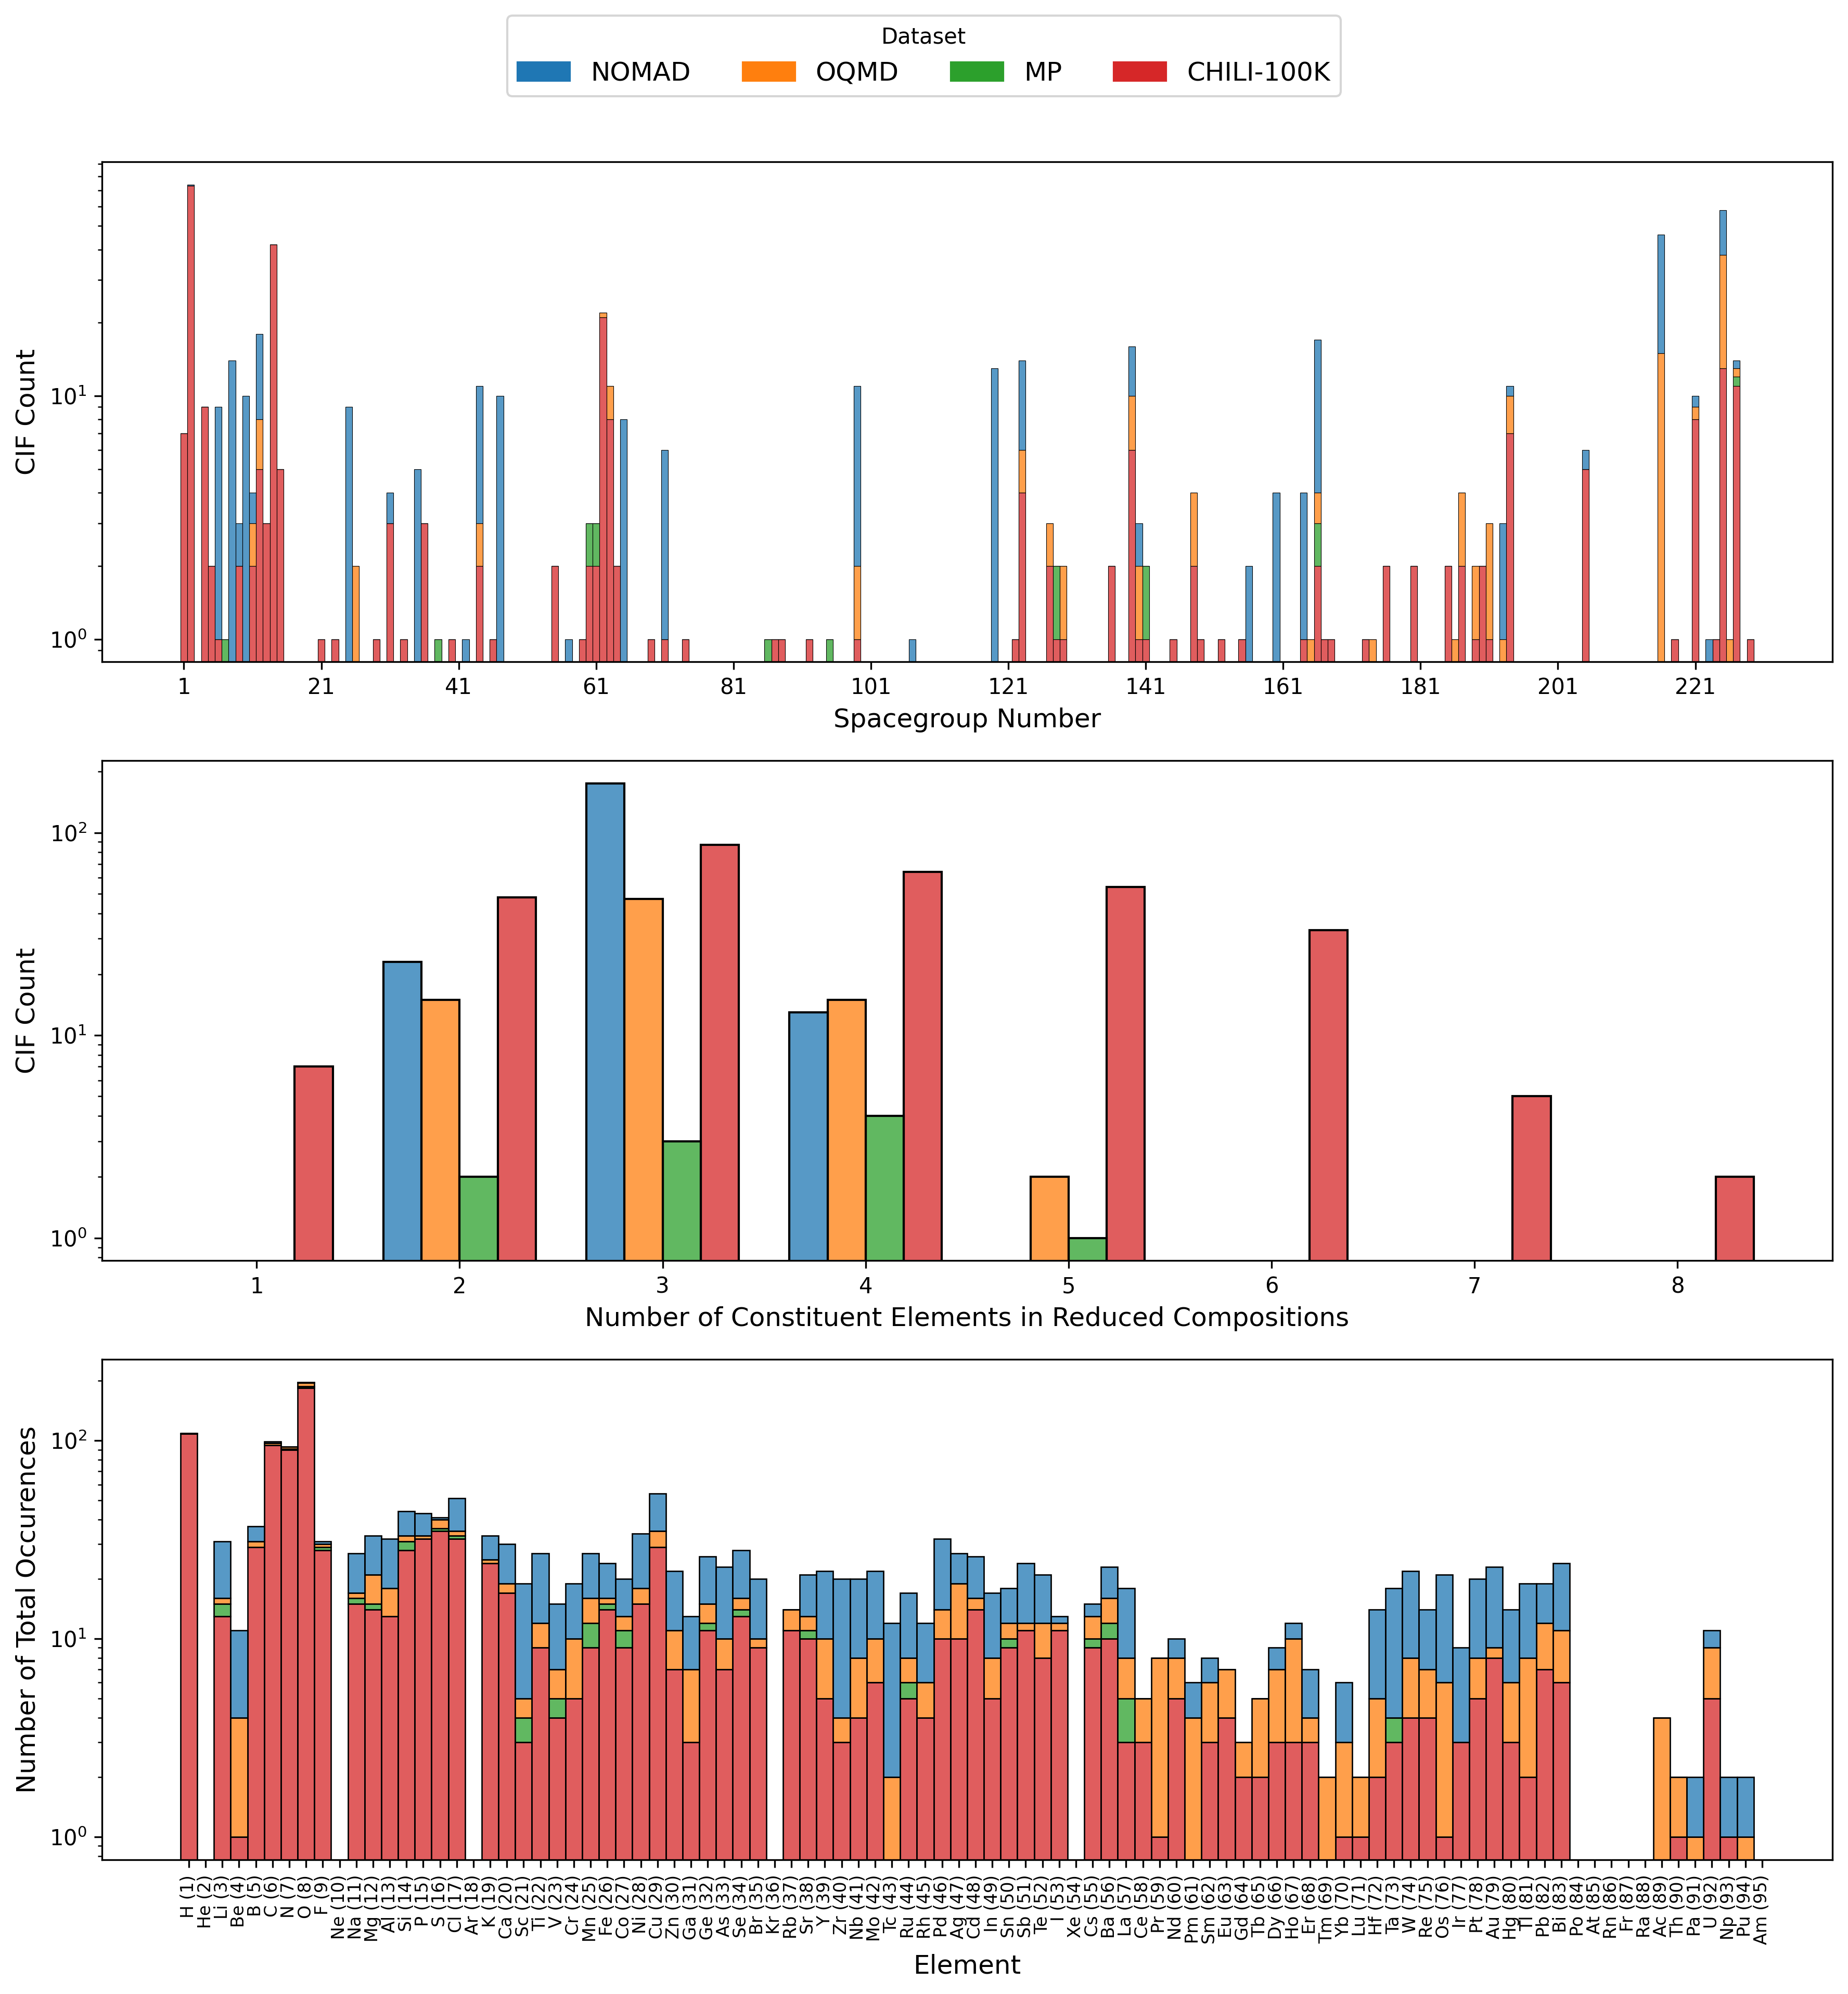

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch

COLORS = sns.color_palette()

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=300)
# plt.subplots_adjust(top=0.85, wspace=0.3)

# Plot 1: spacegroup_num
sns.histplot(
    data=data_df,
    x="spacegroup_num",
    hue="dataset",
    ax=axes[0],
    multiple='stack',
    bins=230,
    edgecolor='k',
    legend=False,
    discrete=True
)
axes[0].set_yscale('log')
axes[0].set_xticks(np.arange(1, 230, 20))
axes[0].set_xlabel('Spacegroup Number')
axes[0].set_ylabel('CIF Count')

# 2
sns.histplot(
    data=exploded_df,
    x="species",
    hue="dataset",
    ax=axes[2],
    multiple='stack',
    edgecolor='k',
    legend=False,
    discrete=True
)
axes[2].set_yscale('log')
axes[2].set_xlabel('Element')
axes[2].set_ylabel('Number of Total Occurences')
axes[2].set_xticks(np.arange(0, len(species_order_labels), 1))
axes[2].set_xticklabels(species_order_labels)
axes[2].tick_params(axis='x', labelrotation=90, labelsize=8)

# Plot 3
sns.histplot(
    data=data_df,
    x="num_elements",
    hue="dataset",
    ax=axes[1],
    multiple='dodge',
    bins=94,
    edgecolor='k',
    legend=False,
    discrete=True,
    shrink=0.75,
)
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Constituent Elements in Reduced Compositions')
axes[1].set_ylabel('CIF Count')
axes[1].tick_params(axis='x')

# Custom handles and labels
handles = [
    Patch(color=COLORS[0], label='NOMAD'),
    Patch(color=COLORS[1], label='OQMD'),
    Patch(color=COLORS[2], label='MP'),
    Patch(color=COLORS[3], label='CHILI-100K')
]
labels = ['NOMAD', 'OQMD', 'MP', 'CHILI-100K']
fig.legend(
    handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07),
    ncol=4, frameon=True, title='Dataset'
)
fig.tight_layout()

fig.savefig("dataset_statistics.pdf", transparent=True, bbox_inches='tight', dpi=300)

plt.show()